# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [1]:

import json
import warnings
import os
from PIL import Image

from datetime import datetime, date, timedelta
from pytz import timezone
from numbers import Number

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt, dates as mdates, cbook, image 

# credits and installation https://github.com/njchiang/tikhonov.git
from sklearn.linear_model import LinearRegression
from tikhonov.TikhonovRegression import Tikhonov

from scipy import stats

# Markov chain Monte Carlo
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano

warnings.simplefilter(action="ignore", category=(FutureWarning,UserWarning))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### set to `True` to update the files with the results:

In [2]:
UPDATE_RESULTS = True

In [3]:
BASE_DATA_PATH = '../data'
BASE_IMAGES_PATH = '../images'

In [4]:
SAVE_IMAGE_PATH=None
if UPDATE_RESULTS:
    SAVE_IMAGE_PATH=os.path.join(
        BASE_IMAGES_PATH, 'TD_Rt_computation_MCMC_300dpi.{}'
    )

In [5]:
def plot_series(title, df=None, yfields=None, data=None, xfield='data', ylim=None, xlim=None, path=None, dpi=300, legendloc='upper left'):

    if data is None and df is not None:
        data=[{}]
        data[0]['df'] = df
        data[0]['yfields'] = yfields
        data[0]['labels'] = yfields
        
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)    
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    for d in data:
        df = d['df']
        yfields = d['yfields']
        if 'labels' in d:
            labels = d['labels']
        else:
            labels = yfields
            
        for f in yfields:
            dates = df[xfield].dt.normalize()
            ax1.plot(
                dates, 
                df[f], 
                label=labels[yfields.index(f)], 
                linestyle=':', marker='o'
            )

    _ = ax1.legend(fontsize=27, loc=legendloc)   
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'))

In [6]:
def plot_MCMC_sampling(df, column, ISS_df, ylim=(0,3), xlim=None, average=True, std=True, conf_int=False, path=None, dpi=None, title=''):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    updatemessage = 'Aggiornamento del {}'.format(df.data.max().strftime('%d %b %Y'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)
        
    date = df['data'].dt.normalize()
    ax1.plot(
        date, 
        df['{}_Rt_MCMC'.format(column)], 
        label='Stima di $R_t$ sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
        marker='o', color = 'orange'
    )

    if conf_int:
        ax1.fill_between(
            date, 
            df['{}_Rt_MCMC_CI_95_min'.format(column)],
            df['{}_Rt_MCMC_CI_95_max'.format(column)],
            color='orange', alpha=.3,
            label="95% confidence interval"
        )

    print('{}_Rt_MCMC_HDI_95_min'.format(column))
    ax1.fill_between(
        date, 
        df['{}_Rt_MCMC_HDI_95_min'.format(column)],
        df['{}_Rt_MCMC_HDI_95_max'.format(column)],
        color='violet', alpha=.3, 
        label = '95% credible interval'
    )

    if average:
        ax1.plot(
            date, 
            df['{}_Rt_MCMC_avg14'.format(column)], 
            label='Avg14 Rt MCMC Estimate - {}'.format(column),
            marker='o', color = 'green'
        )    

    if std:
        ax1.fill_between(
            date, 
            df['{}_Rt_MCMC_CI_95_14_min'.format(column)],
            df['{}_Rt_MCMC_CI_95_14_max'.format(column)],
            color='blue', alpha=.25,
            label="95% confidence interval on 14 days average"
        )

    ISS_ref_date = ISS_df.Rt_reference_date.dt.normalize()
    ax1.errorbar(
        ISS_ref_date, 
        ISS_df.Rt, 
        ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
        uplims=True, lolims=True,
        label='Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con intervallo di credibilità 95%',
        marker='o', color = 'blue'
    )

    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'), optimize=True, quality=60)

# Two data sources

We have two official data sources:

- ISS data (Istituto Superiore della Sanita')
- pcm-dpc data (Protezione Civile)

See https://www.epicentro.iss.it/coronavirus/sars-cov-2-sorveglianza , at "Perché le informazioni fornite dall’ISS possono differire (essere in ritardo) rispetto a quelle della Protezione civile"


## ISS data (Istituto Superiore della Sanita')

These data are available via the Ministero della Sanita' web site, not in their raw format, but only via descriptive reports.

To obtain the data  one needs to navigate (or scrape) the intricated and non standardized structure of the weekly reports from ministero della Sanita'

What follows is the result of the scraping, aimed to obtain the $Rt$ values computed by ISS.

In the "url" column the url to the official report is reported.

To update the ISS dataset, check manuallty [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.

In [7]:
ISS_Rt = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_from_ISS.csv'),
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [8]:
ISS_Rt.head()

ID            report_time_range_descr  \
0  5313              25/01/2021-31/01/2021   
1  5299                18/1/2021-24/1/2021   
2  5289               11 - 17 gennaio 2021   
3  5268                 4/1/2021-10/1/2021   
4  5259  28 dicembre 2020 - 3 gennaio 2021   

         computation_time_range_descr computation_time_range_start  \
0        13 gennaio – 26 gennaio 2021                   2021-01-13   
1        06 gennaio – 19 gennaio 2021                   2021-01-06   
2  30 dicembre 2020 – 12 gennaio 2021                   2020-12-30   
3  23 dicembre 2020 – 05 gennaio 2021                   2020-12-23   
4               15 – 28 dicembre 2020                   2020-12-15   

  computation_time_range_end    Rt  Rt_95_min  Rt_95_max  \
0                 2021-01-26  0.84       0.76       1.02   
1                 2021-01-19  0.84       0.75       0.98   
2                 2021-01-12  0.97       0.85       1.11   
3                 2021-01-05  1.09       1.04       1.13   
4                 2020-12-28  1.03       0.98       1.13   

                    Rt_text       report_data notes       source  \
0   0,84 (range 0,76– 1,02)  03 febbraio 2021   NaN  attachement   
1   0,84 (range 0,75– 0,98)   27 gennaio 2021   NaN  attachement   
2   0,97 (range 0,85– 1,11)   20 gennaio 2021   NaN  attachement   
3   1,09 (range 1,04– 1,13)   13 dcembre 2021   NaN  attachement   
4  1,03 (range 0,98 – 1,13)    5 gennaio 2021   NaN  attachement   

  source_detail                                                url  \
0           NaN  http://www.salute.gov.it/imgs/C_17_monitoraggi...   
1           NaN  http://www.salute.gov.it/imgs/C_17_monitoraggi...   
2           NaN  http://www.salute.gov.it/imgs/C_17_notizie_528...   
3           NaN  http://www.salute.gov.it/imgs/C_17_notizie_526...   
4           NaN  http://www.salute.gov.it/imgs/C_17_notizie_525...   

               link  
0  03 febbraio 2021  
1   27 gennaio 2021  
2   20 gennaio 2021  
3   13 dcembre 2021  
4    5 gennaio 2021

In [9]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [10]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = ISS_Rt_clean.Rt - ISS_Rt_clean.Rt_95_min

In [11]:
ISS_Rt_clean['Rt_reference_date'] = (
    (
        ISS_Rt_clean.computation_time_range_start + 
        (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, minutes=-1)
)
ISS_Rt_clean.sort_values(by='Rt_reference_date', inplace=True)
ISS_Rt_clean.reset_index(inplace=True, drop=True)

In [12]:
ISS_Rt_clean.tail()

computation_time_range_start computation_time_range_end    Rt  Rt_95_min  \
21                   2020-12-15                 2020-12-28  1.03       0.98   
22                   2020-12-23                 2021-01-05  1.09       1.04   
23                   2020-12-30                 2021-01-12  0.97       0.85   
24                   2021-01-06                 2021-01-19  0.84       0.75   
25                   2021-01-13                 2021-01-26  0.84       0.76   

    Rt_95_max  Rt_95_err_max  Rt_95_err_min   Rt_reference_date  
21       1.13           0.10           0.05 2020-12-21 23:59:00  
22       1.13           0.04           0.05 2020-12-29 23:59:00  
23       1.11           0.14           0.12 2021-01-05 23:59:00  
24       0.98           0.14           0.09 2021-01-12 23:59:00  
25       1.02           0.18           0.08 2021-01-19 23:59:00

In [13]:
ISS_Rt_clean_save = ISS_Rt_clean[[
    'computation_time_range_start', 'computation_time_range_end', 'Rt_reference_date', 
    'Rt', 'Rt_95_min', 'Rt_95_max'
]]
if UPDATE_RESULTS:
    ISS_Rt_clean_save.to_csv(
        os.path.join(BASE_DATA_PATH,'computed/Rt_from_ISS_processed.csv'),
        float_format='%.2f',
        index=False        
    )
    ISS_Rt_clean_save.to_excel(
        os.path.join(BASE_DATA_PATH,'computed/Rt_from_ISS_processed.xlsx'),
        float_format='%.2f',
        index=False        
    )    

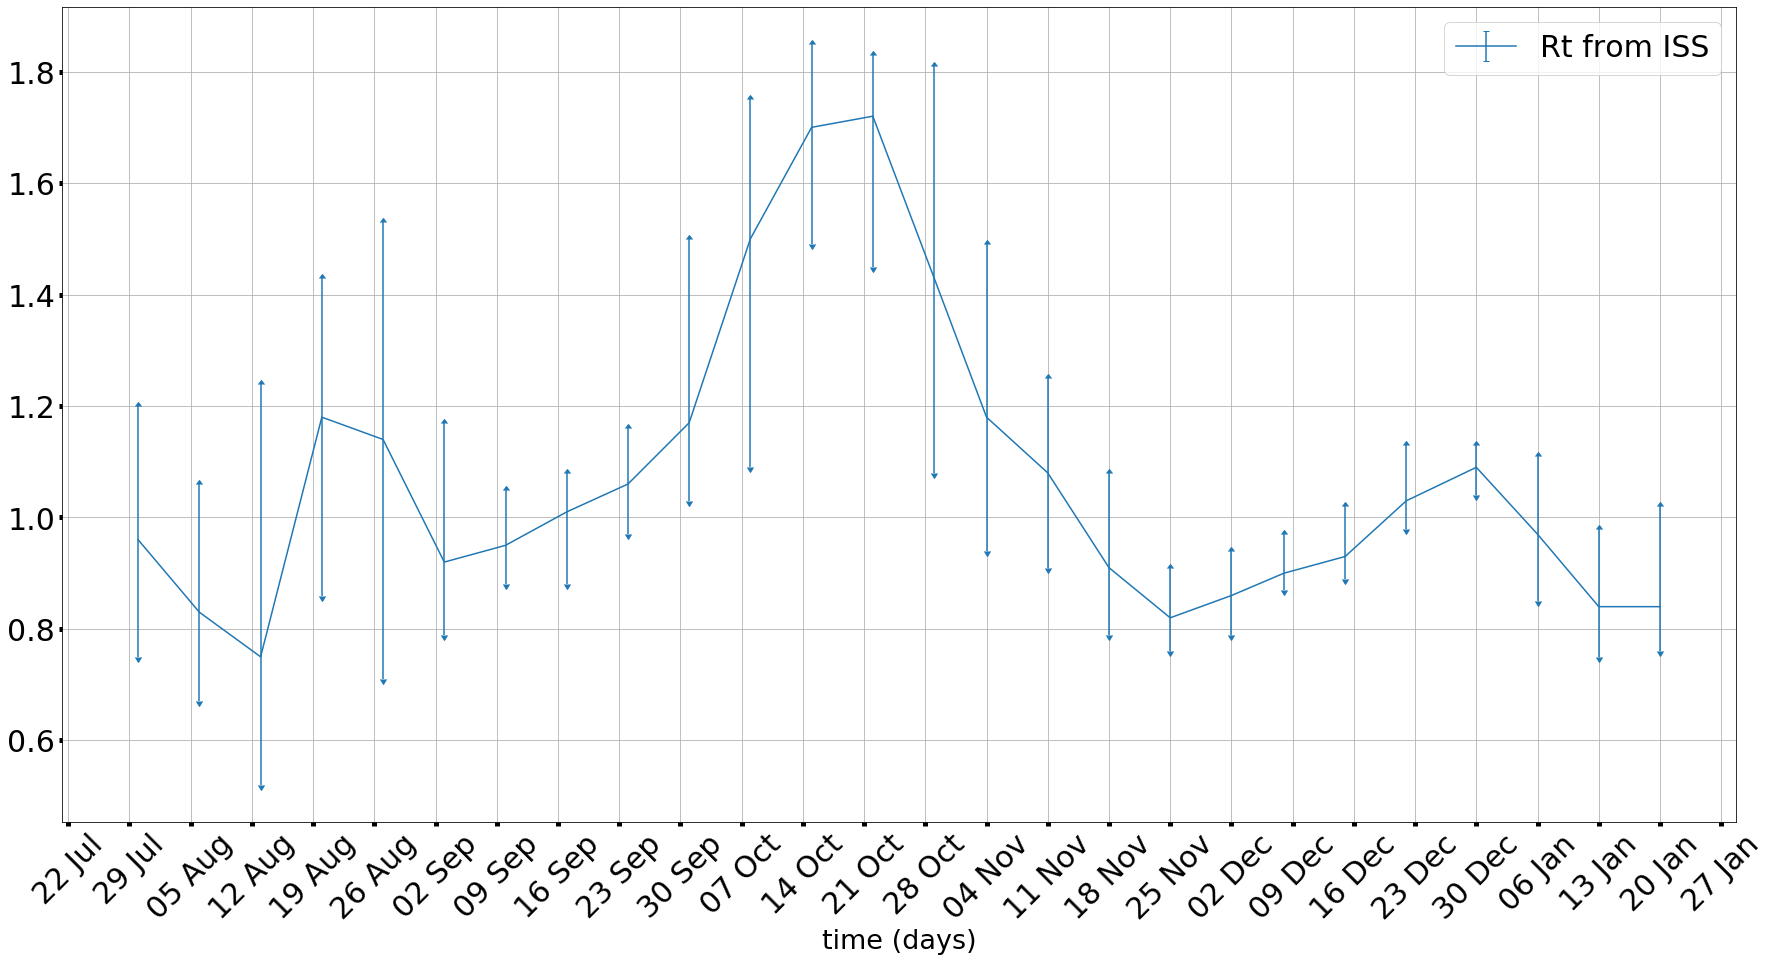

In [14]:
fig, ax1 = plt.subplots(figsize=(30,15))

ax1.set_xlabel('time (days)', fontsize=27)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax1.xaxis.set_tick_params(width=5)
ax1.yaxis.set_tick_params(width=5)

ax1.grid()    

ax1.set_ylabel('', fontsize=30)
ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS'
)

_ = ax1.legend(fontsize=30)

By the way, this happens to be the only publicly available chart of the ISS computed Rt value, at least to my knowledge.

## Assessing the confidence interval

- why are confidence intervals so different?
- why are they so big?

Confidence bars seems pretty related with the derivative of the signal.
Given that the ISS $R_t$ is the average over 14 days, the hypothesis could be that the confidence intervals are simpli an estimate of the slope of the 14 points averaged. 
The bigger the slope the bigger the confidence interval.

Let's check this hypothesis comparing the amplitude of the confidence intervals with $2(R_{t} - R_{t-7})$, with $2$ being motivated by the fact that the points are 7 days distant, while the averages are taken on 14 days ranges.


In [15]:
ISS_Rt_clean['Rt_95_CI'] = 2*ISS_Rt_clean.Rt_95_err_max
#ISS_Rt_clean['Rt_2_abs_D'] = 2*(np.abs(ISS_Rt_clean.Rt - ISS_Rt_clean.Rt.shift(1)))
ISS_Rt_clean['Rt_2_abs_D'] = 2*np.abs(ISS_Rt_clean.Rt.diff())

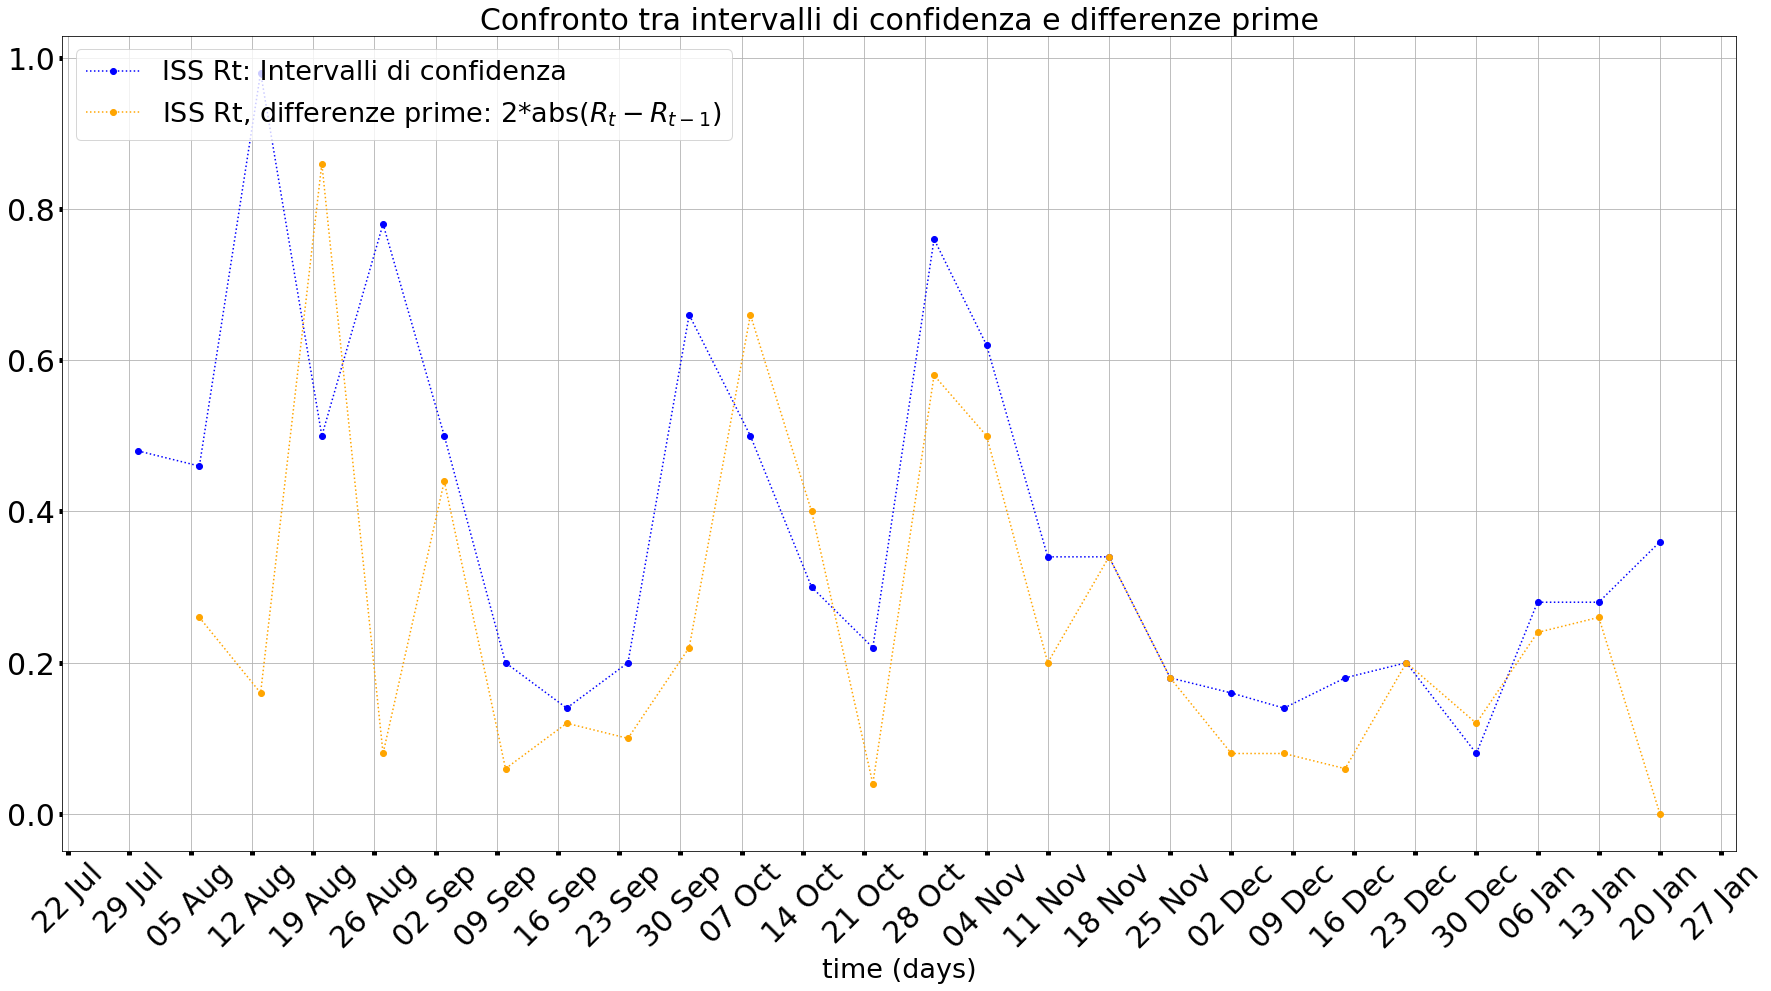

In [16]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Confronto tra intervalli di confidenza e differenze prime', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=27)
ax1.tick_params(axis='both', labelsize=30)

ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax1.xaxis.set_tick_params(width=5)
ax1.yaxis.set_tick_params(width=5)

ax1.grid()    

ax1.plot(
    ISS_Rt_clean.Rt_reference_date,
    ISS_Rt_clean.Rt_95_CI, 
    label='ISS Rt: Intervalli di confidenza', 
    linestyle=':', marker='o', color = 'blue'
)

ax1.plot(
    ISS_Rt_clean.Rt_reference_date,
    ISS_Rt_clean.Rt_2_abs_D,
    label='ISS Rt, differenze prime: 2*abs($R_{t}-R_{t-1}$)', 
    linestyle=':', marker='o', color = 'orange'
)

_ = ax1.legend(fontsize=27, loc='upper left')    


#diffintimg = os.path.join(BASE_IMAGES_PATH, '20210115_diffint.{}')
#plt.savefig(diffintimg.format('png'), dpi=150)
#im = Image.open(diffintimg.format('png'))
#rgb_im = im.convert('RGB')
#rgb_im.save(diffintimg.format('jpg'), quality=60, optimize=True)

# pcm-dpc data (Protezione Civile)

In [17]:
def parse_date_pcm(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [18]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date_pcm
)

In [19]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')

In [20]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [21]:
italy_raw_data.describe()

ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
count              352.000000         352.000000            352.000000   
mean             13045.127841        1434.698864          14479.829545   
std              11344.825446        1347.061624          12668.351628   
min                101.000000          26.000000            127.000000   
25%               1787.000000         151.500000           1958.000000   
50%               9678.500000         885.000000          10696.500000   
75%              23314.000000        2580.000000          25916.000000   
max              34697.000000        4068.000000          38507.000000   

       isolamento_domiciliare  totale_positivi  variazione_totale_positivi  \
count              352.000000       352.000000                  352.000000   
mean            196453.196023    210933.022727                 1175.414773   
std             250223.002323    260215.998974                 7529.927085   
min                 94.000000       221.000000               -27010.000000   
25%              18375.250000     21152.000000                -1259.500000   
50%              52515.500000     66483.500000                  160.500000   
75%             426722.000000    449183.750000                 1576.250000   
max             767867.000000    805947.000000                33418.000000   

       nuovi_positivi  dimessi_guariti      deceduti  \
count      352.000000     3.520000e+02    352.000000   
mean      7552.761364     4.532008e+05  39570.707386   
std       9818.965301     5.805869e+05  21908.599750   
min         78.000000     1.000000e+00      7.000000   
25%        517.500000     1.361800e+05  32583.500000   
50%       2318.500000     2.040550e+05  35402.500000   
75%      13221.250000     4.022870e+05  44275.000000   
max      40902.000000     2.149350e+06  92002.000000   

       casi_da_sospetto_diagnostico  ...   totale_casi       tamponi  \
count                    162.000000  ...  3.520000e+02  3.520000e+02   
mean                  345928.216049  ...  7.037046e+05  1.123421e+07   
std                   217856.889628  ...  8.091122e+05  9.937626e+06   
min                        0.000000  ...  2.290000e+02  4.324000e+03   
25%                   223237.500000  ...  2.284950e+05  3.299933e+06   
50%                   236256.500000  ...  2.544355e+05  7.615071e+06   
75%                   341673.000000  ...  1.116615e+06  1.851234e+07   
max                   988470.000000  ...  2.655319e+06  3.478126e+07   

       casi_testati  ingressi_terapia_intensiva  note_test  note_casi  \
count  2.970000e+02                   69.000000        0.0        0.0   
mean   7.653100e+06                  162.753623        NaN        NaN   
std    5.149923e+06                   31.847710        NaN        NaN   
min    9.353100e+05                   97.000000        NaN        NaN   
25%    3.322447e+06                  144.000000        NaN        NaN   
50%    5.956171e+06                  156.000000        NaN        NaN   
75%    1.272941e+07                  183.000000        NaN        NaN   
max    1.783972e+07                  256.000000        NaN        NaN   

       totale_positivi_test_molecolare  \
count                     2.600000e+01   
mean                      2.494703e+06   
std                       8.514171e+04   
min                       2.351466e+06   
25%                       2.425926e+06   
50%                       2.495251e+06   
75%                       2.561648e+06   
max                       2.629894e+06   

       totale_positivi_test_antigenico_rapido  tamponi_test_molecolare  \
count                               26.000000             2.600000e+01   
mean                             12510.807692             3.032911e+07   
std                               7898.460584             1.038019e+06   
min                                957.000000             2.861735e+07   
25%                               5703.500000             2.949630e+07   
50

In [22]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [23]:
italy_raw_data.loc[
    italy_raw_data.totale_positivi 
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']
]

data  totale_positivi  dimessi_guariti  deceduti  \
254 2020-11-04 23:59:00           443235           307378     39747   
345 2021-02-03 23:59:00           434722          2059248     89819   

     totale_casi  
254       790377  
345      2583790

In [24]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    != italy_raw_data.totale_ospedalizzati,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']    
]

data  ricoverati_con_sintomi  terapia_intensiva  \
1 2020-02-25 23:59:00                     114                 35   

   totale_ospedalizzati  
1                   150

In [25]:
italy_raw_data.loc[
    italy_raw_data.totale_ospedalizzati 
    + italy_raw_data.isolamento_domiciliare 
    != italy_raw_data.totale_positivi,
    ['data', 'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi']    
]

data  totale_ospedalizzati  isolamento_domiciliare  \
1 2020-02-25 23:59:00                   150                     162   

   totale_positivi  
1              311

In [26]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    != italy_raw_data.totale_positivi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'totale_positivi']    
]

Empty DataFrame
Columns: [data, ricoverati_con_sintomi, terapia_intensiva, isolamento_domiciliare, totale_positivi]
Index: []

In [27]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'dimessi_guariti', 'deceduti', 'totale_casi']    
]

data  ricoverati_con_sintomi  terapia_intensiva  \
254 2020-11-04 23:59:00                   22116               2292   
345 2021-02-03 23:59:00                   20071               2145   

     isolamento_domiciliare  dimessi_guariti  deceduti  totale_casi  
254                  418827           307378     39747       790377  
345                  412506          2059248     89819      2583790

# Fix NaN data

`casi_da_sospetto_diagnostico` and `casi_da_screening` have been measured only after a certain date

In [28]:
FIRST_CASI_SOSP_DIAGNOSTICO = italy_raw_data.casi_da_sospetto_diagnostico.first_valid_index()
italy_raw_data.loc[FIRST_CASI_SOSP_DIAGNOSTICO,['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [29]:
italy_raw_data.loc[italy_raw_data.casi_da_screening.first_valid_index(),['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [30]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)

# Compute new cases

In [31]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1)).fillna(0)

In [32]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1)).fillna(0)

# Smoothing data via Tikhonov regularization

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a byproduct of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tri`, `np.ones` and `np.eye`.


In [33]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [34]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [35]:
def smooth_data(y, X, L, alpha, verbose=True):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    if verbose:
        print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha, verbose=True):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    if verbose:
        print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

## Alternative to fitting, the analytic solution

$${\displaystyle {\hat {x}}=(A^{\top }A+\Gamma ^{\top }\Gamma )^{-1}A^{\top }\mathbf {b} }$$

In [36]:
def get_Tikhonov_matrix(steps, alpha):
    X, G = filter_matrices(steps)
    
    return np.dot(
        np.linalg.inv(
            np.dot(X.T, X) + np.dot(alpha * G.T, alpha * G)
        ), 
        X.T
    )

## Apply the smoothing

In [37]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.9999936495824899


In [38]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.9999838710838462


In [39]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=200.)

TIC R2: 0.9999925383515087


In [40]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999941628589015


In [41]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_sospetto_diagnostico,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9670646326920035


In [42]:
italy_raw_data['nuovi_casi_da_screening_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_screening,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9617533467602758


In [43]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi', 'casi_da_screening',
    'casi_da_sospetto_diagnostico'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.9997767184479203
TIC R2: 0.9998554633593106
TIC R2: 0.9998766326853871
TIC R2: 0.9998865209438407
TIC R2: 0.9999838710838462
TIC R2: 0.9999929683665202
TIC R2: 0.9999936495824899
TIC R2: 0.9999941628589015
TIC R2: 0.9617533467602758
TIC R2: 0.9670646326920035


# Residuals

Check the residuals of the raw signals versus the smoothed ones, specifically for the following fields:

- `nuovi_positivi`
- `nuovi_casi_da_accertamento_diagnostico`
- `nuovi_casi_da_screening`

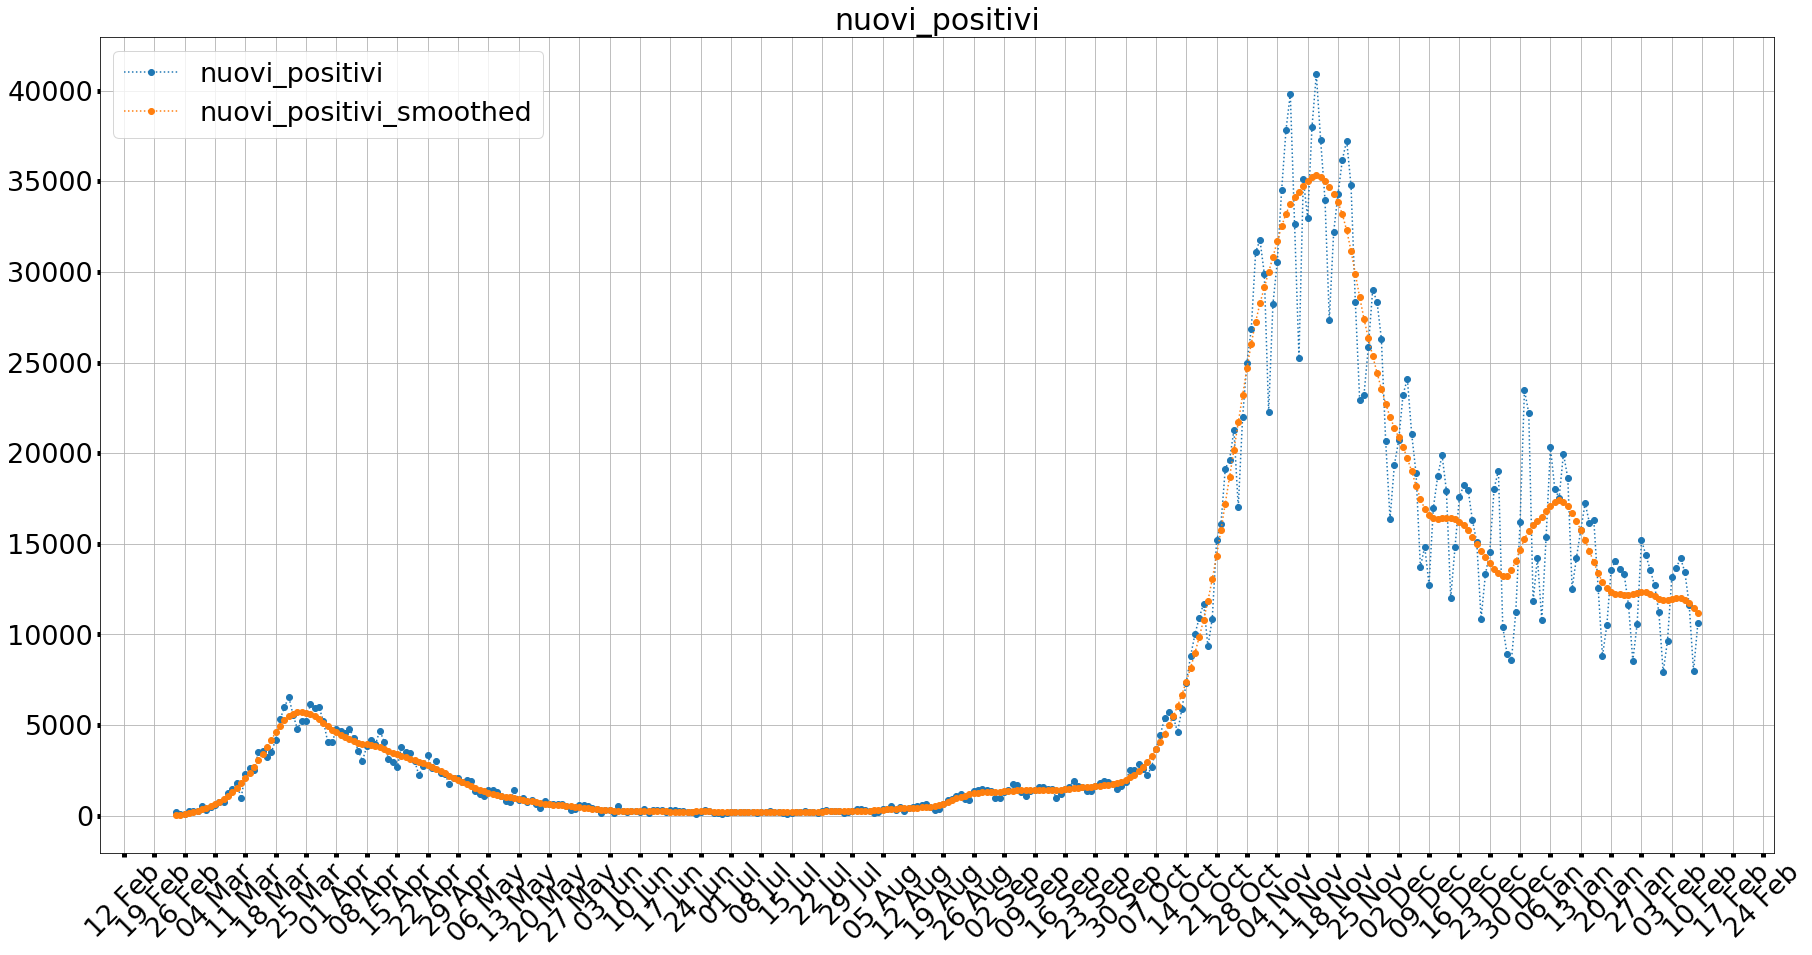

In [44]:
plot_series(
    'nuovi_positivi',    
    italy_raw_data, 
    [
        'nuovi_positivi',
        'nuovi_positivi_smoothed'
    ]
)

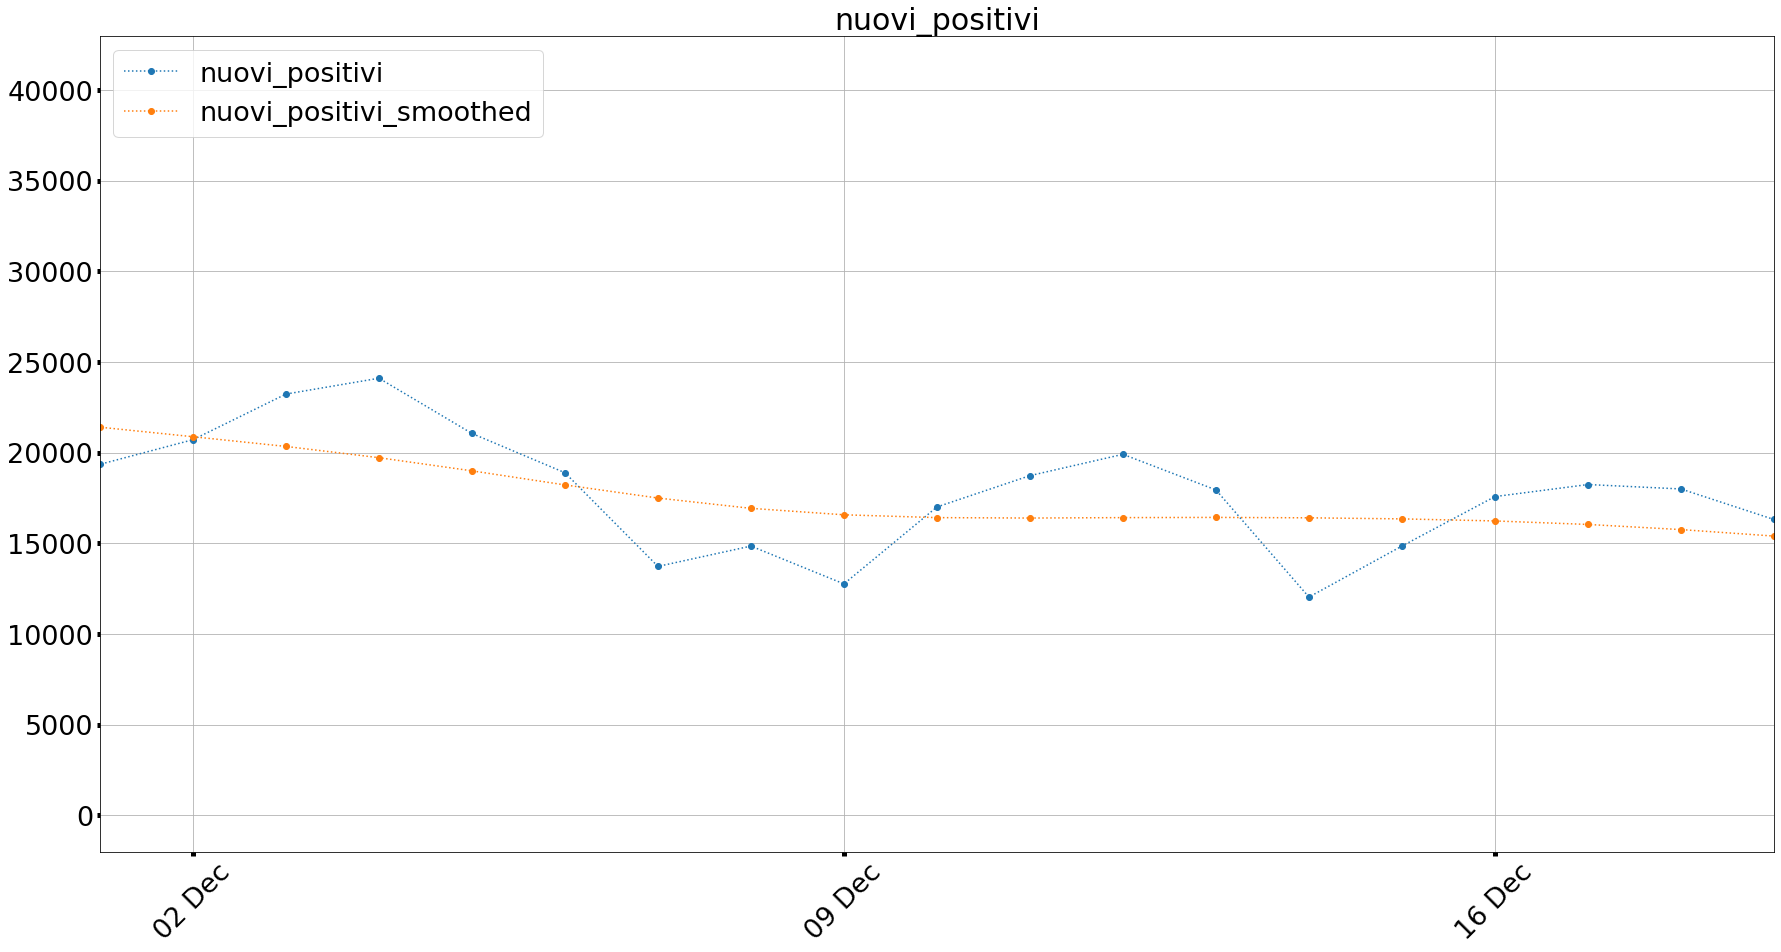

In [45]:
plot_series(
    'nuovi_positivi',    
    italy_raw_data, 
    [
        'nuovi_positivi',
        'nuovi_positivi_smoothed'
    ],
    xlim=(datetime(2020,12,1), datetime(2020,12,19))
)

In [46]:
italy_raw_data['nuovi_positivi_residuals'] = (
    italy_raw_data.nuovi_positivi - italy_raw_data.nuovi_positivi_smoothed
)
italy_raw_data['nuovi_positivi_relative_residuals'] = (
    italy_raw_data.nuovi_positivi_residuals / italy_raw_data.nuovi_positivi_smoothed
)
italy_raw_data.loc[0,'nuovi_positivi_relative_residuals'] = 0

In [47]:
italy_raw_data['nuovi_positivi_residuals_sigma7'] = italy_raw_data.nuovi_positivi_residuals.rolling(
    window=7
).std()

italy_raw_data.nuovi_positivi_residuals_sigma7.fillna(
    italy_raw_data.nuovi_positivi_residuals_sigma7[
        italy_raw_data.nuovi_positivi_residuals_sigma7.first_valid_index()
    ],
    inplace=True
)

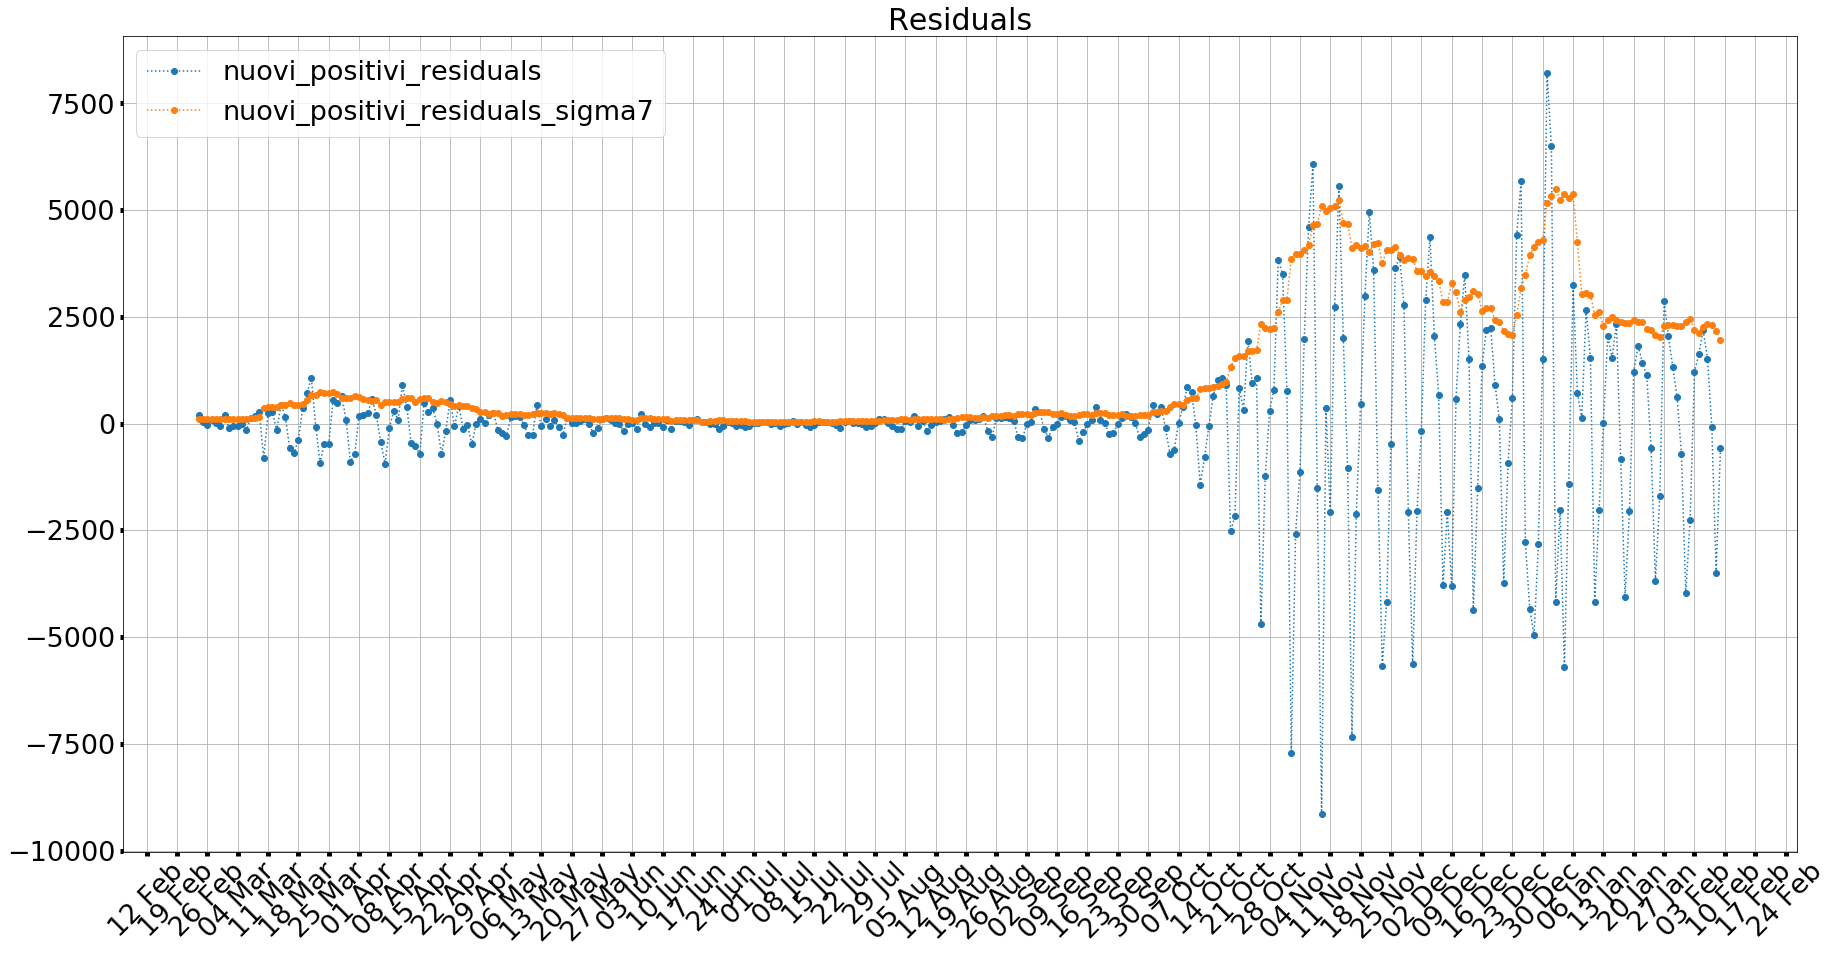

In [48]:
plot_series(
    'Residuals',    
    italy_raw_data, 
    [
        'nuovi_positivi_residuals',
        'nuovi_positivi_residuals_sigma7',
    ],
    #ylim=(0.2,3)
)

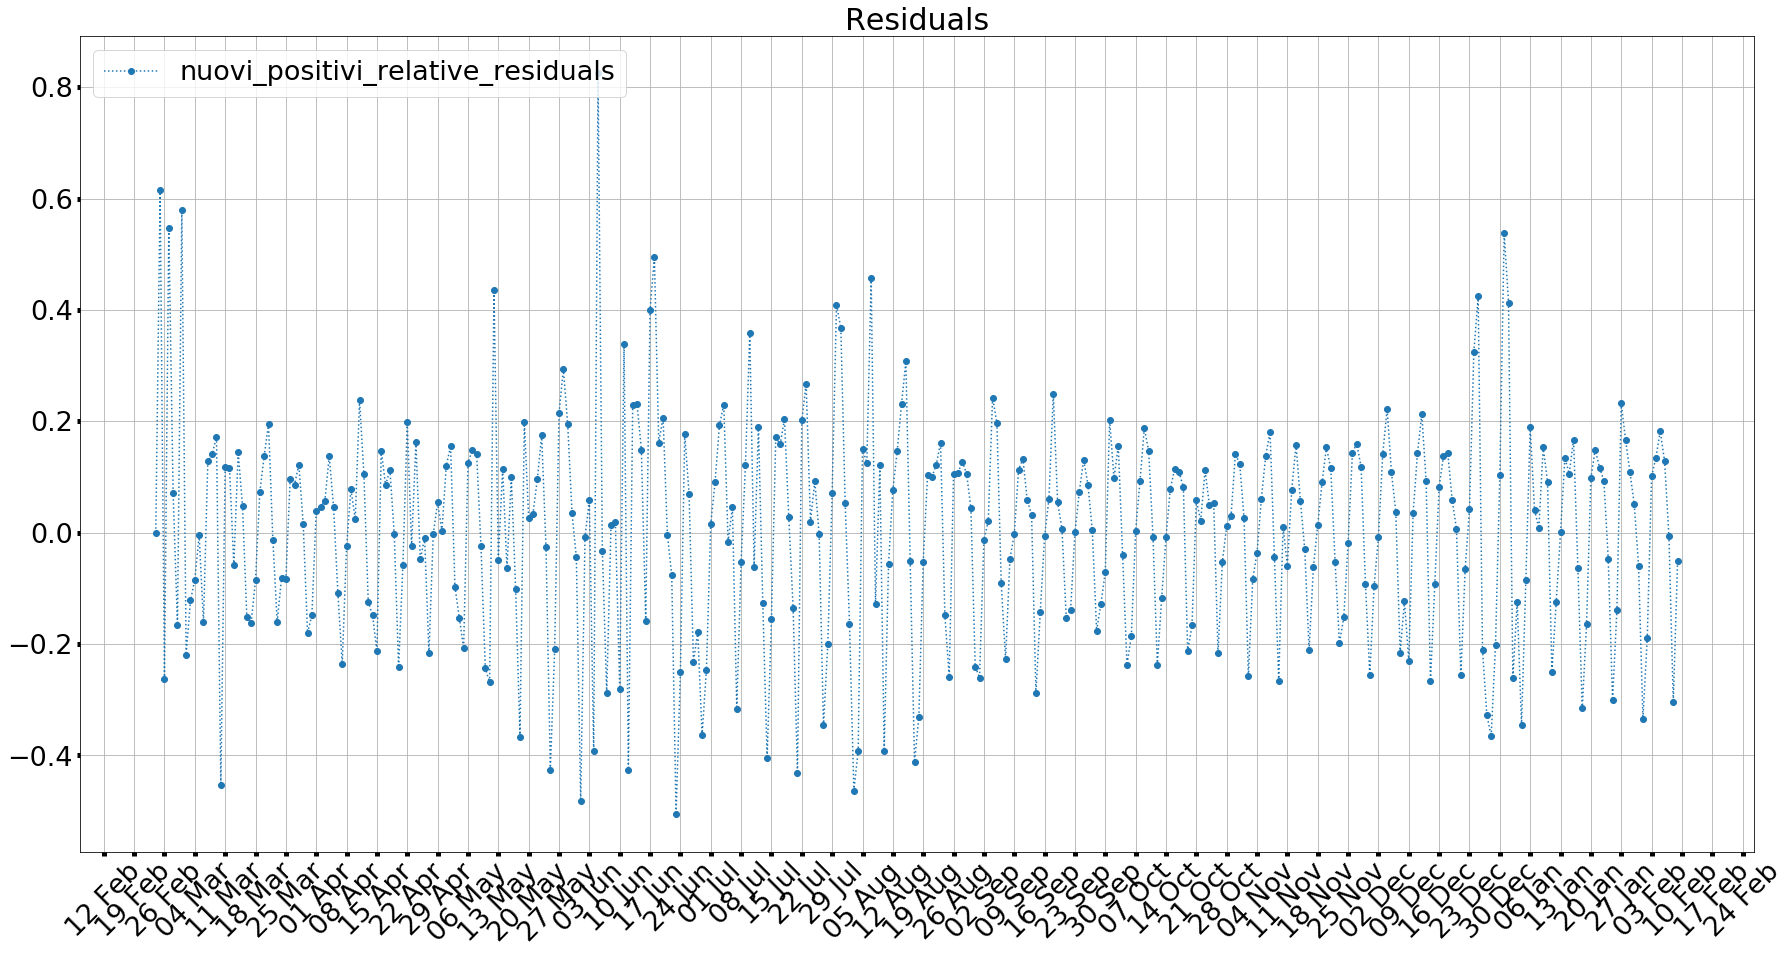

In [49]:
plot_series(
    'Residuals',    
    italy_raw_data, 
    [
        'nuovi_positivi_relative_residuals'
    ],
    #ylim=(0.2,3)
)

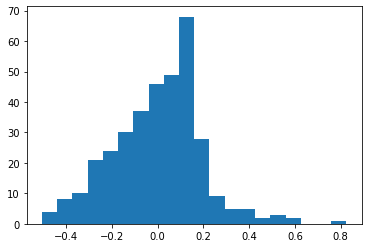

In [50]:
_= plt.hist(italy_raw_data.nuovi_positivi_relative_residuals, bins=20)

# Compute $R_t$

Definitions and parameters values are form Ref: https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt

$R_t$ si defined as:

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

Where:
- $I_t$ is `nuovi_positivi` at day t, or any first difference of a cumulative value
- $w_s=\Gamma(s; \alpha,\beta)$, [the Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)
- $\alpha = 1.87$
- $\beta = 0.28$

In [51]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [52]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [53]:
def infectious_charge(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge_ = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return np.asarray(infectious_charge_)

In [54]:
def Rt(series, alpha, beta):
    infectious_charge_ = infectious_charge(series, alpha, beta)
    
    return series / infectious_charge_

## Compute $R_t$ on every first difference available

Computation is performed for the following fields:
- `nuovi_positivi`: first difference of `nuovi_casi`
- `nuovi_casi_da_sospetto_diagnostico`: first difference of `casi_da_sospetto_diagnostico`
- `nuovi_casi_da_screening`: first difference of `casi_da_screening`

Each computation is performed both on the raw values **and on the smoothed values**.

In [55]:
alpha = 1.87
beta = 0.28

rt_on_fields = [
    'nuovi_positivi',
    'nuovi_casi_da_sospetto_diagnostico',
    'nuovi_casi_da_screening'
]

for c in rt_on_fields + ['{}_smoothed'.format(c) for c in rt_on_fields]:
    italy_raw_data['{}_Rt'.format(c)] = Rt(italy_raw_data[c], alpha=alpha, beta=beta).fillna(0)

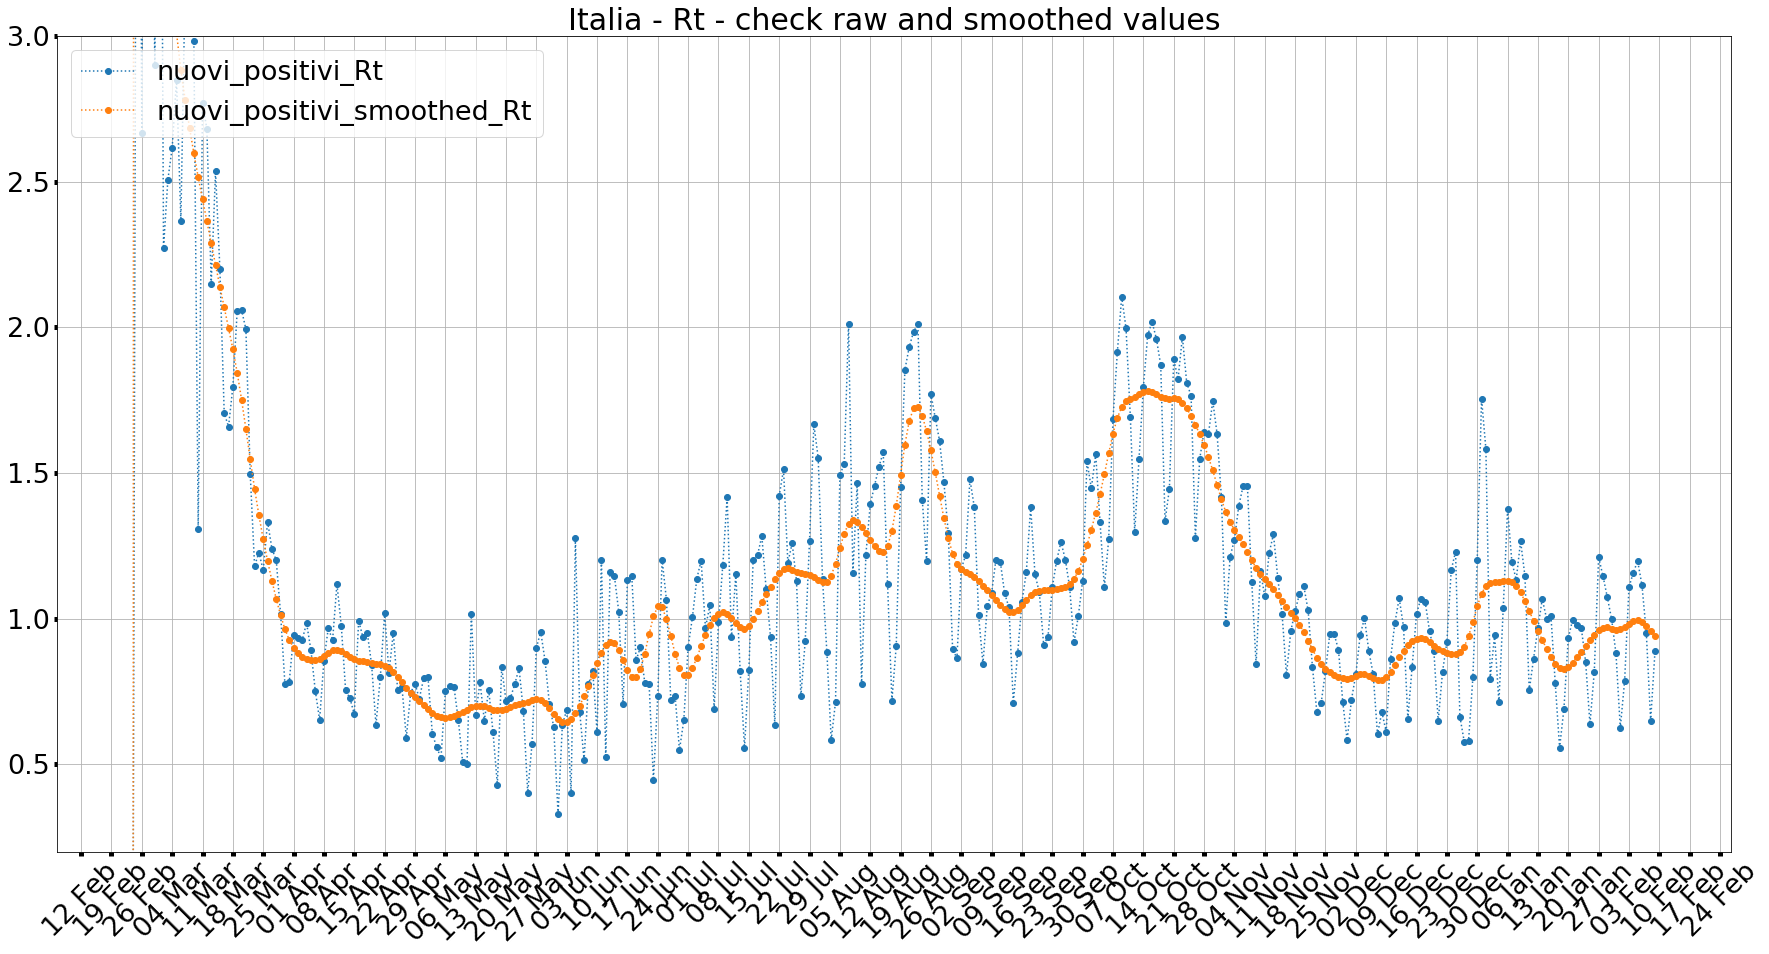

In [56]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.2,3)
)

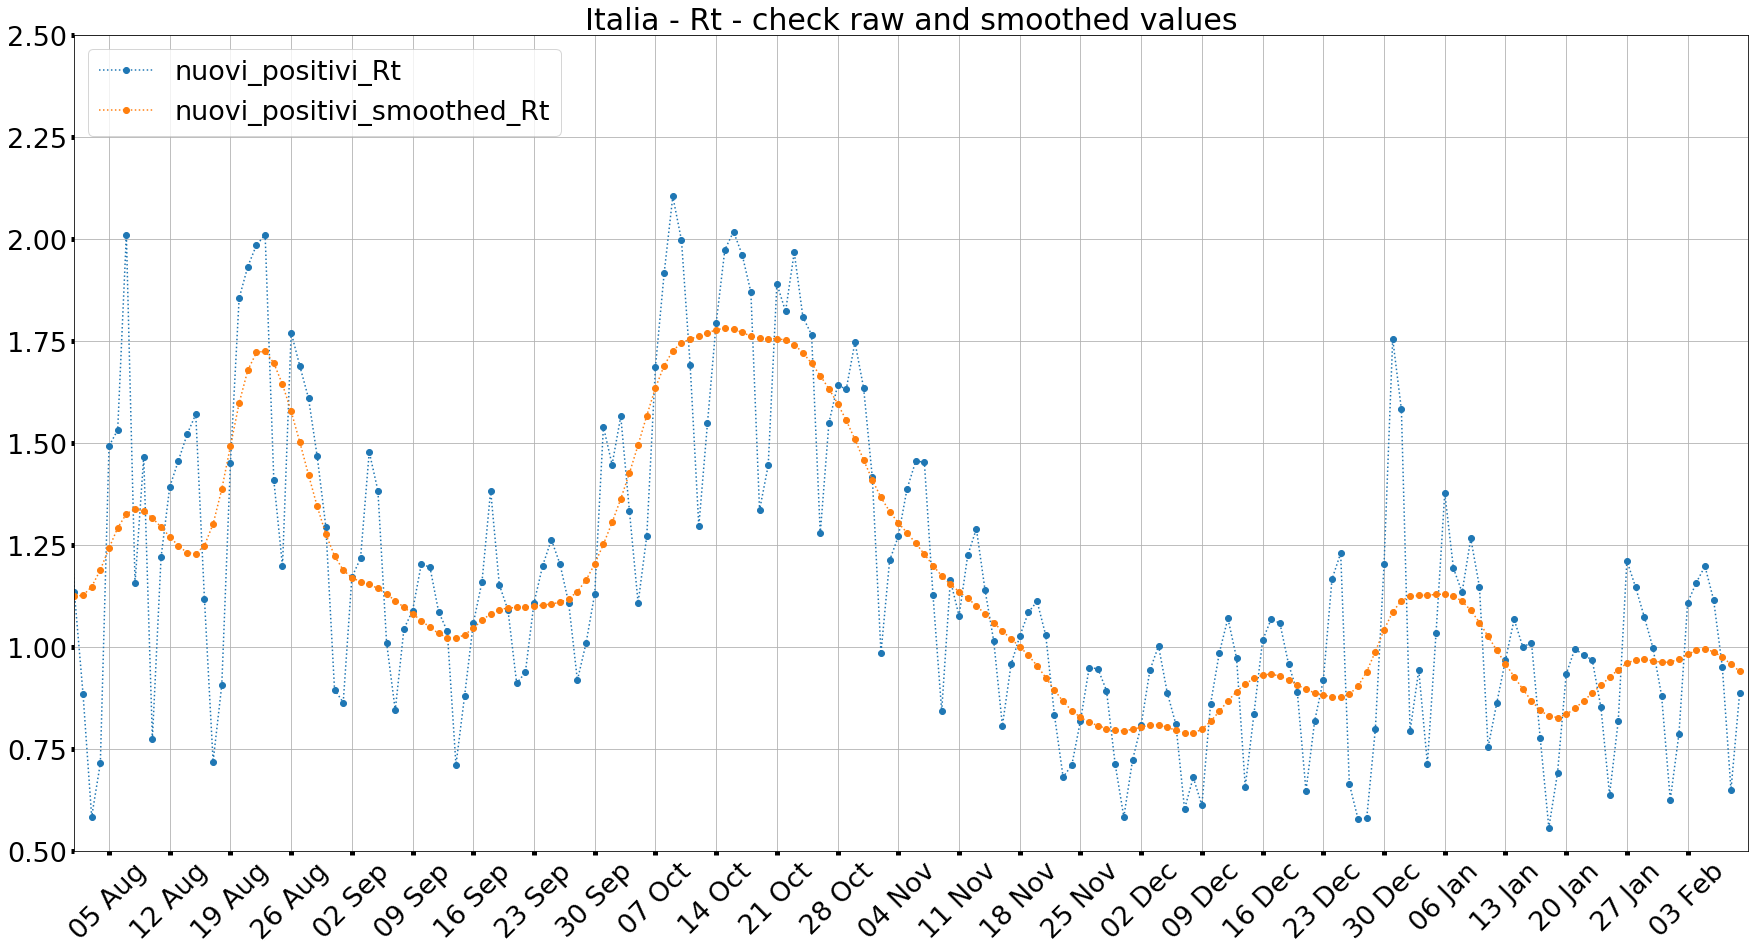

In [57]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.5,2.5),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

## Compare $R_t$ values computed on the 3 first differences

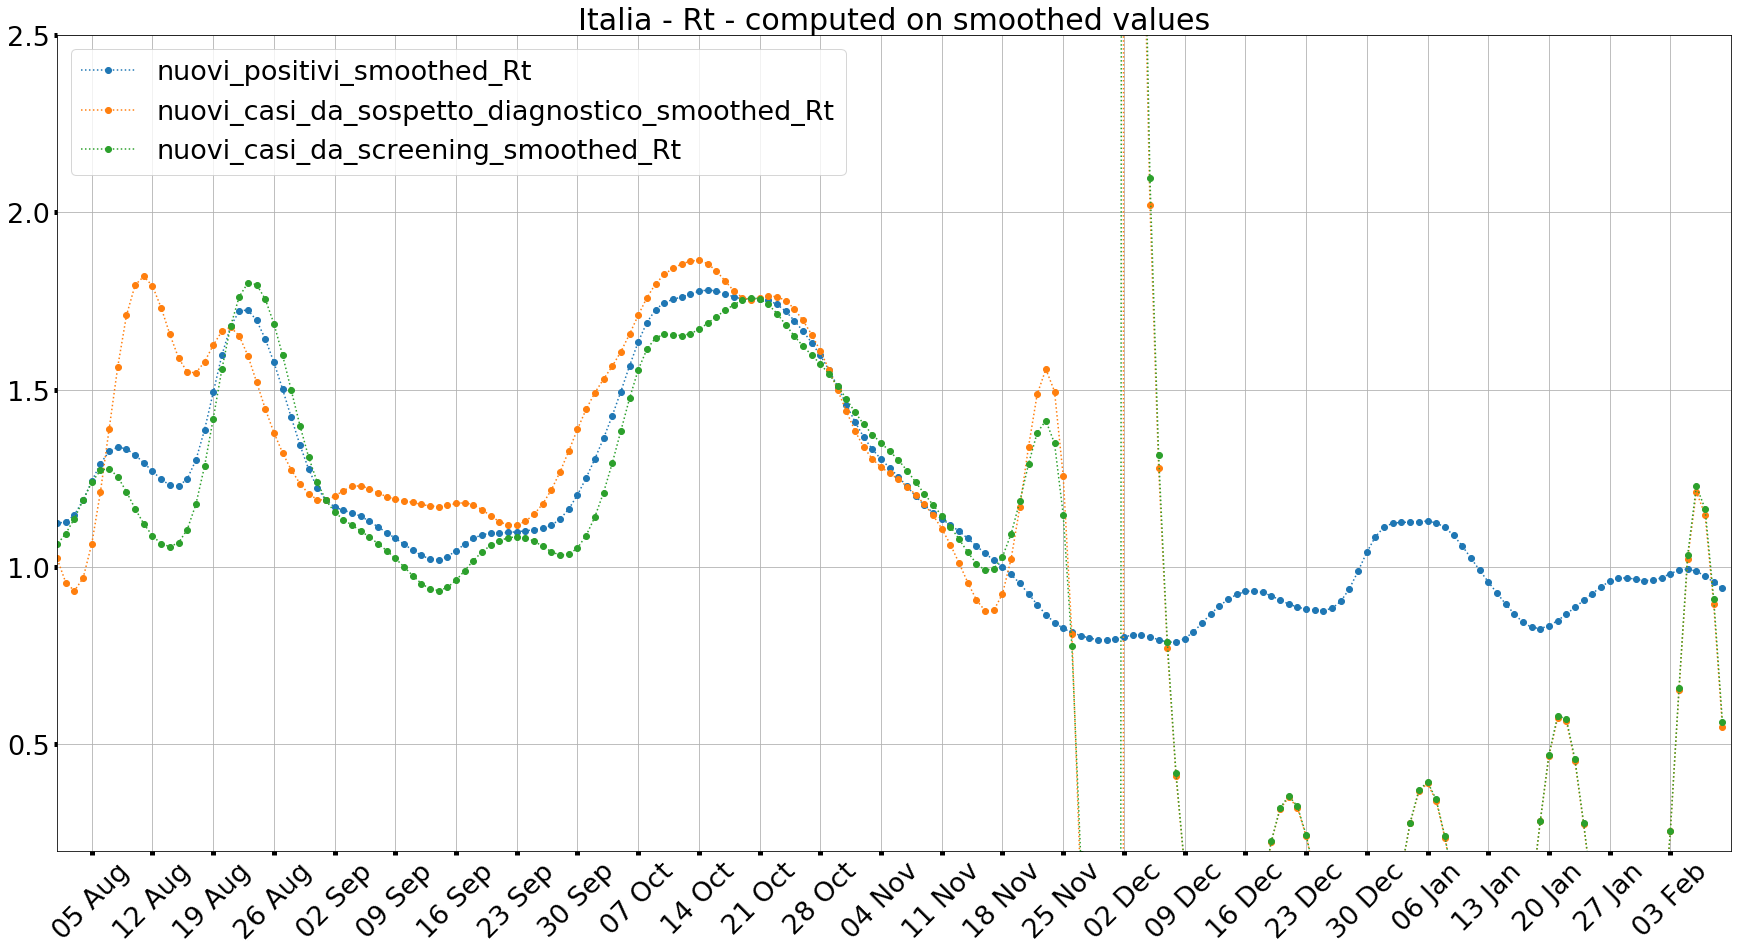

In [58]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

### On the divergence of the $R_t$ when computed on `casi_da_sospetto_diagnostico` and `nuovi_casi_da_screening` 

Both `casi_da_sospetto_diagnostico` and `nuovi_casi_da_screening` are zero from Dec 3rd onwards.

This is a problem with the communication of data by the public administrations.

In [59]:
italy_raw_data.casi_da_sospetto_diagnostico[-10:]

342    0.0
343    0.0
344    0.0
345    0.0
346    0.0
347    0.0
348    0.0
349    0.0
350    0.0
351    0.0
Name: casi_da_sospetto_diagnostico, dtype: float64

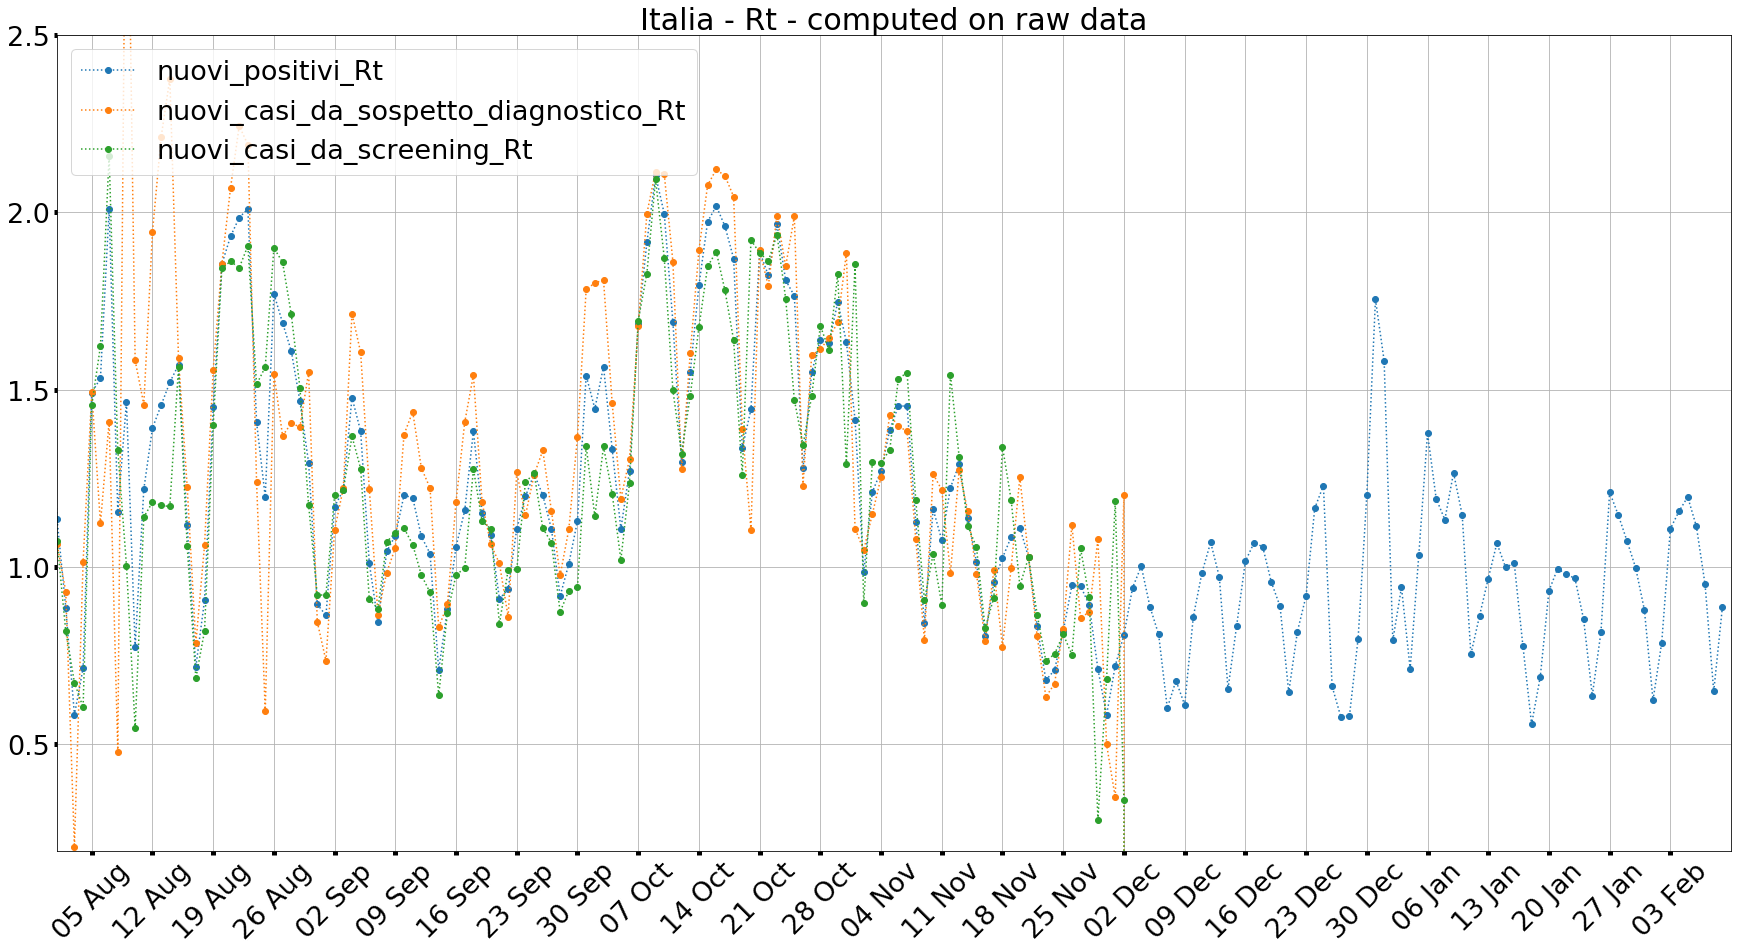

In [60]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_casi_da_sospetto_diagnostico_Rt',
        'nuovi_casi_da_screening_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

# Assess $R_t$ via perturbations

Let's add a perturbation $p_t$ to the original cumulative signal, and compute again the first difference:

$$\large{C_t = \sum_{s=1}^{t} I_t}$$

$$\large{\hat{C}_t = C_t + p_t}$$

$$\large{\hat{I}_t = \hat{C}_t-\hat{C}_{t-1}}$$


## Rate perturbation

The rate pertubation is defined as:

$$\large{p_{t+1} = p_t  (1+r_t)} $$

where:
- $r_t$ is the growth rate of the perturbation; it can be a function of time.

In [61]:
def growth(v,rate, zerosteps, steps):
    assert(zerosteps < steps)
    if isinstance(rate, Number):
        ratefunc = lambda s: rate
    elif callable(rate):
        ratefunc = rate
    else:
        raise Exception("rate must be either a number or a function")
    for s in range(steps):
        if s <= zerosteps:
            yield 0.
        else:
            r = ratefunc(s)
            v = v * (1. + r)
            yield v

In [62]:
p0 = 40.
rate=0.1
perturbation = pd.Series(growth(p0,rate, FIRST_CASI_SOSP_DIAGNOSTICO, TIMESTEPS))

cumulative_hat = italy_raw_data.casi_da_sospetto_diagnostico + perturbation

nuovi_casi_hat = smooth_differentiate(
    cumulative_hat,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

nuovi_perturbation = smooth_differentiate(
    perturbation,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

Rt_nuovi_casi_hat = Rt(nuovi_casi_hat, alpha=alpha, beta=beta)
Rt_perturbation = Rt(nuovi_perturbation, alpha=alpha, beta=beta)

italy_raw_data['perturbation_Rt'] = Rt_perturbation
italy_raw_data.perturbation_Rt.fillna(0, inplace=True)

italy_raw_data['casi_da_sospetto_diagnostico_smoothed_perturbed_Rt'] = Rt_nuovi_casi_hat
italy_raw_data.casi_da_sospetto_diagnostico_smoothed_perturbed_Rt.fillna(0, inplace=True)


TIC R2: 0.9999954925073845
TIC R2: 0.9999954925389755


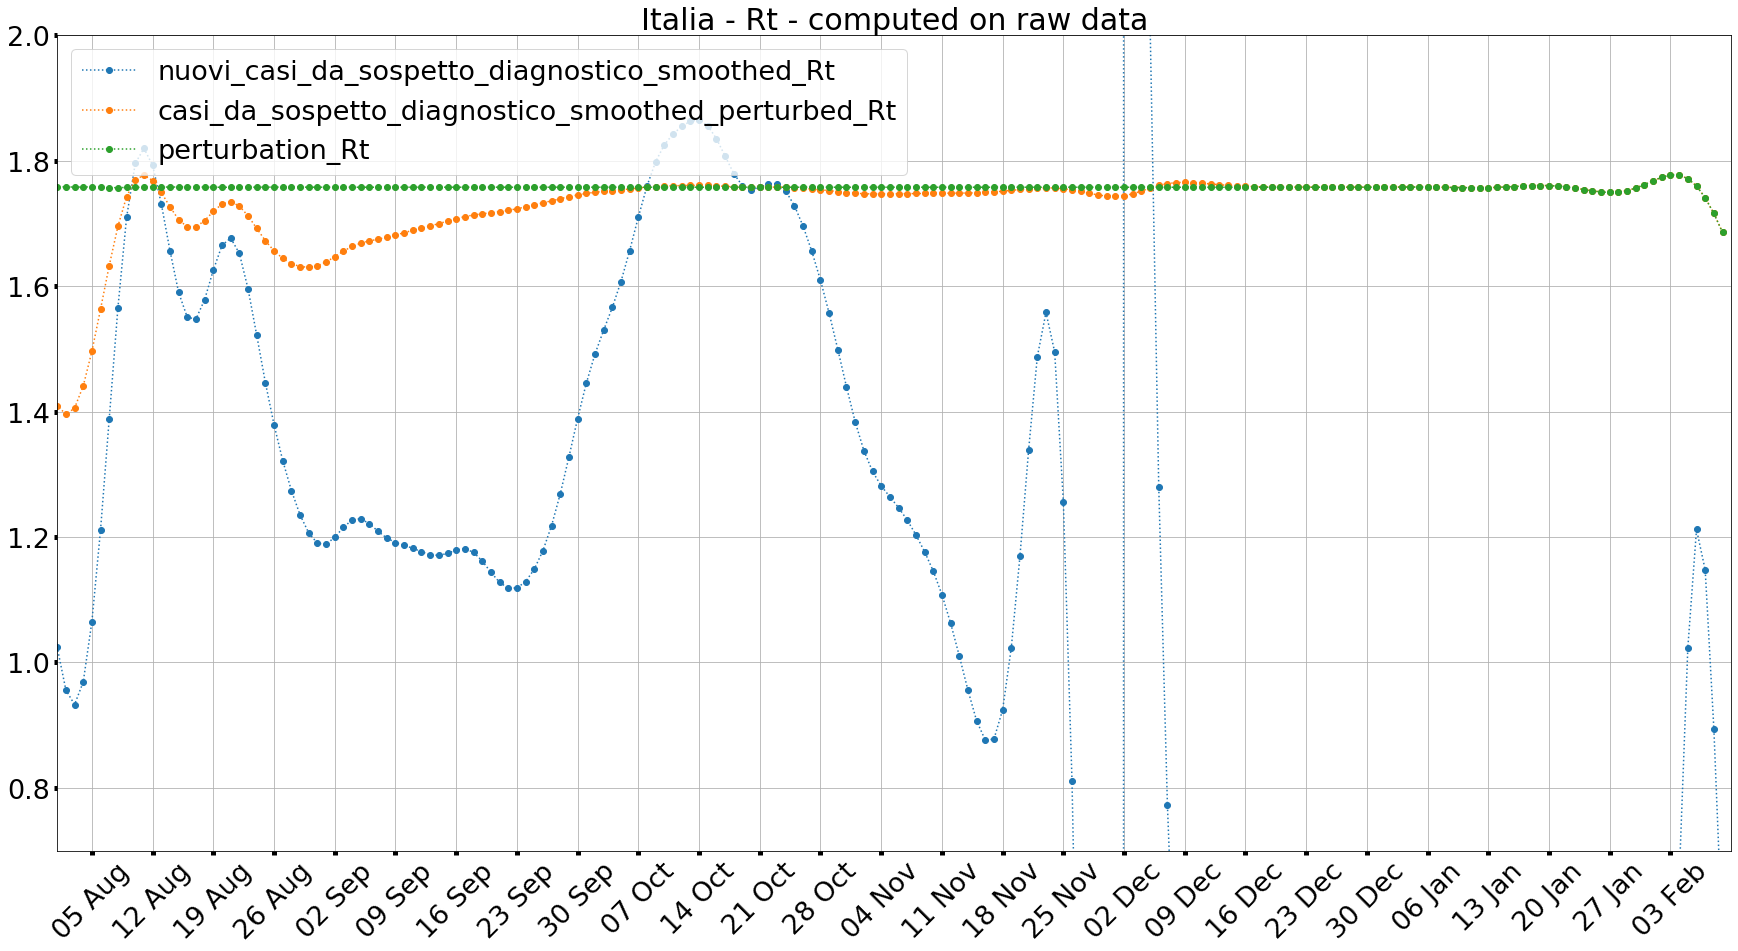

In [63]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'casi_da_sospetto_diagnostico_smoothed_perturbed_Rt',
        'perturbation_Rt'
    ],
    ylim=(0.7,2),
    xlim=(datetime(2020,8,1),italy_raw_data.data.max())
)

# Comparison of ISS and realtime Rt values

In [64]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of ISS and realtime Rt values', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=45)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax1.xaxis.set_tick_params(width=5)
ax1.yaxis.set_tick_params(width=5)
ax1.grid()    
with open(os.path.join(BASE_IMAGES_PATH, 'watermark.png'), 'rb') as file:
    im = image.imread(file)
fig.figimage(im, 1150, 850, zorder=3, alpha=.5)        

ax1.set_ylim(0.7,2)
ax1.set_xlim(datetime(2020,7,1),italy_raw_data.data.max())

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_smoothed_Rt, 
    label='nuovi_positivi_Rt', 
    linestyle=':', marker='o', color = 'orange'
)

ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS',
    marker='o', color = 'blue'
)


_ = ax1.legend(fontsize=27, loc='upper left')    

# Estimating $R_t$ with Markov chain Monte Carlo

In [65]:
def pad_window(a, start, window=None):
    if not window:
        window = 0
    
    return np.pad(
        a,
        [(start+1,window)] + [(0,0)]*(len(a.shape)-1), 
        mode='constant', 
        constant_values=np.nan
    )

def save_MCMC_sampling(df, column, trace, interval=0.95, start=0, window=None):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df['{}_Rt_MCMC'.format(column)] = pad_window(sampling_mean, start, window)
    
    df['{}_Rt_MCMC_avg14'.format(column)] = df['{}_Rt_MCMC'.format(column)].rolling(
        window=14, center=True
    ).mean()
    
    # confidence interval 14
    conf_int_14 = stats.norm.interval(
        interval, 
        df['{}_Rt_MCMC_avg14'.format(column)],
        df['{}_Rt_MCMC'.format(column)].rolling(
                window=14, center=True
        ).std()
    )
    
    df['{}_Rt_MCMC_CI_{}_14_min'.format(column, interval_frac)] = conf_int_14[0]
    df['{}_Rt_MCMC_CI_{}_14_max'.format(column, interval_frac)] = conf_int_14[1]

    #credible interval
    sampling_hdi = pad_window(
        pm.stats.hpd(trace['r_t'], hdi_prob=interval), 
        start, window
    )


    df['{}_Rt_MCMC_HDI_{}_min'.format(column, interval_frac)] = sampling_hdi[:,0]
    df['{}_Rt_MCMC_HDI_{}_max'.format(column, interval_frac)] = sampling_hdi[:,1]

    # confidence interval
    conf_int = stats.norm.interval(
        interval, 
        sampling_mean,
        np.std(trace['r_t'], axis=0)
    )

    df['{}_Rt_MCMC_CI_{}_min'.format(column, interval_frac)] = pad_window(conf_int[0], start, window)
    df['{}_Rt_MCMC_CI_{}_max'.format(column, interval_frac)] = pad_window(conf_int[1], start, window)
    
    

In [66]:
def MCMC_sample(
    onset, 
    alpha, 
    beta, 
    start=0, window=None, 
    chains=1, tune=4000, draws=4000, 
    target_accept=0.95, 
    dry=False, 
    cores=None,
    progressbar=True
):

    if not window:
        window = len(onset)
        
    if type(onset)==pd.DataFrame:
        onset = onset.values
        
    onset_ = onset[start:start+window]
    
    with pm.Model() as model:
                
        # draws R_t from a prior normal distribution
        r_t = pm.Normal("r_t", mu=1.3, sigma=10., shape=len(onset_)-1)

        # compute the exptect number of current infectious 
        # based on the sampled R_t and the know past values of infectious
        infectious_charge_ = infectious_charge(onset_, alpha, beta)[1:]
        expected_today = r_t * infectious_charge_
        
        # Poisson requirements
        mu = pm.math.maximum(.1, expected_today)        
        observed = (onset_[1:]).round()

        # test the posterior: 
        # mu values derived from R_t samples 
        # must converge to the mean of real cases 
        # if they are Poisson distributed, as they are
        cases = pm.Poisson('cases', mu=mu, observed=observed)

        trace = None
        if not dry:
            trace = pm.sample(
                chains=chains,
                cores=cores,
                tune=tune,
                draws=draws,
                target_accept=target_accept,
                progressbar=progressbar)
        
            #assert not trace.diverging.any()
    
    return model, trace

## Sample $R_t$ distribution on `nuovi_positivi` raw series

In [67]:
model_raw, trace_raw = MCMC_sample(
    onset=italy_raw_data.nuovi_positivi,
    alpha=alpha, beta=beta,
    start=0, window=None,
    chains=4,
    tune=4000,
    draws=4000,
    dry=False
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 35 seconds.


In [68]:
save_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi', 
    trace_raw, 
    start=0, window=None
)

nuovi_positivi_Rt_MCMC_HDI_95_min


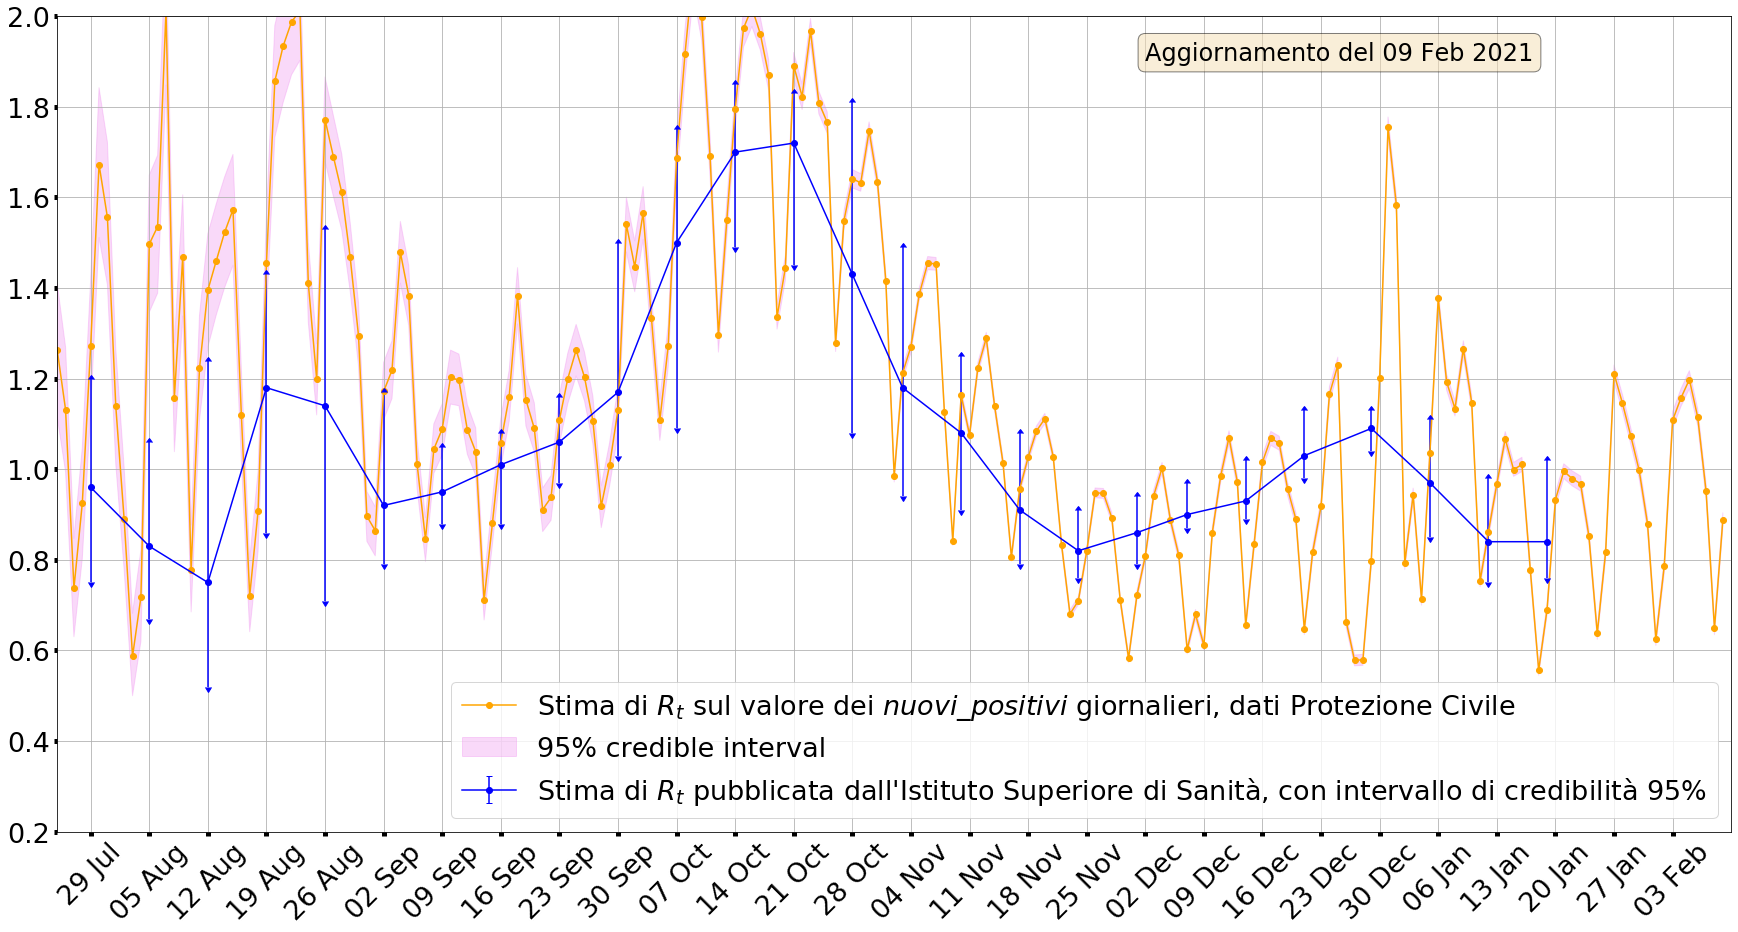

In [69]:
plot_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi', 
    ISS_Rt_clean,
    xlim=(datetime(2020,7,25),italy_raw_data.data.max()), 
    std=False, 
    average=False, 
    ylim=(0.2,2),
)

# Access impacts of future uncertainty on Tikhonov fit

New unexpected values of `nuovi_positivi` can alter retrospectively the fit performed by Tikhonov regularization.

Let's see how.

To do this, we take the smoothed differences of `totale_casi` stopping one day before the available data and see what happens.

The new data lenght is therefore `TIMESTEPS - 1`

Let's call this new smoothed vairable `nuovi_positivi_smoothed_prev`

In [70]:
DEC_3rd_data = italy_raw_data[italy_raw_data.data.dt.normalize()<"2020-12-04"]
TIMESTEPS_DEC_3rd = len(DEC_3rd_data)
INTEGRAL_MATRIX_PREV, SECOND_DERIVATIVE_MATRIX_PREV = filter_matrices(TIMESTEPS_DEC_3rd)

GAMMA_PREV = SECOND_DERIVATIVE_MATRIX_PREV

italy_raw_data['nuovi_positivi_smoothed_DEC_3rd'] = np.pad(
    smooth_differentiate(
        DEC_3rd_data.totale_casi,
        X=INTEGRAL_MATRIX_PREV,
        L=GAMMA_PREV,
        alpha=ALPHA
    ),
    (0,TIMESTEPS-TIMESTEPS_DEC_3rd), 'constant', constant_values=(0,np.nan)
)

TIC R2: 0.9999808652832823


In [71]:
DEC_4th_data = italy_raw_data[italy_raw_data.data.dt.normalize()<"2020-12-05"]
TIMESTEPS_DEC_4th = len(DEC_4th_data)
INTEGRAL_MATRIX_PREV, SECOND_DERIVATIVE_MATRIX_PREV = filter_matrices(TIMESTEPS_DEC_4th)

GAMMA_PREV = SECOND_DERIVATIVE_MATRIX_PREV

italy_raw_data['nuovi_positivi_smoothed_DEC_4th'] = np.pad(
    smooth_differentiate(
        DEC_4th_data.totale_casi,
        X=INTEGRAL_MATRIX_PREV,
        L=GAMMA_PREV,
        alpha=ALPHA
    ),
    (0,TIMESTEPS-TIMESTEPS_DEC_4th), 'constant', constant_values=(0,np.nan)
)

TIC R2: 0.9999811975894978


## Compare the smoothed values computed yesterday with those computed today

In the chart:

- `nuovi_positivi` is the raw signal coming from Protezione Civile
- `nuovi_positivi_smoothed_DEC_3rd` is the signal smoothed with the kowledge we had yesterday (DEC 3rd)
- `nuovi_positivi_smoothed_DEC_4th` is the smoothed signal, computed with data available today (DEC 4th)

The two smoothed signals start separating a few days ago, because **the new data we have today forces us to review our previuos computation.**

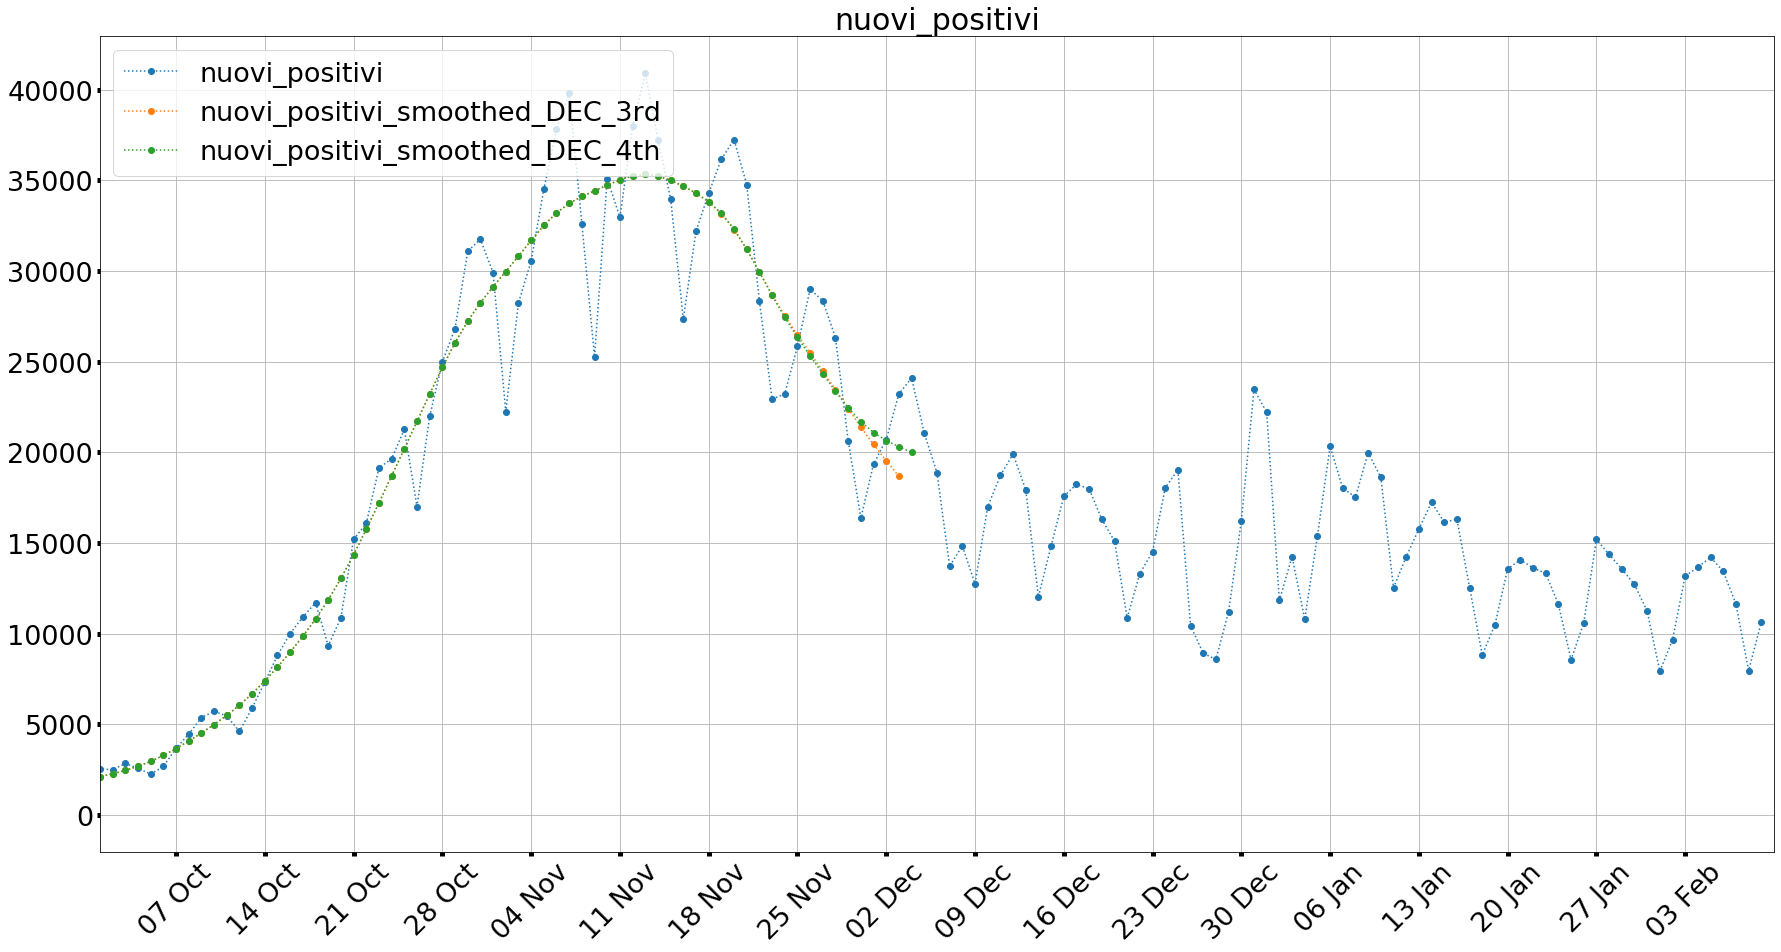

In [72]:
plot_series(
    'nuovi_positivi',    
    italy_raw_data, 
    [
        'nuovi_positivi',
        'nuovi_positivi_smoothed_DEC_3rd',
        'nuovi_positivi_smoothed_DEC_4th'        
    ],
    xlim=(datetime(2020,10,1),italy_raw_data.data.max()), 
)

## Today value of $R_t$ compared with the value computed with yesterday knowledge

This update produced by new data available today impacts on the $R_t$ value as well.

Let's see how, computing the $R_t$ on the signal smoothed yesterday and comparing it with the one we can compute today.

In [73]:
model_prev_, trace_prev_ = MCMC_sample(
    onset=italy_raw_data.nuovi_positivi_smoothed_DEC_3rd,
    alpha=alpha, beta=beta,
    start=0, window=TIMESTEPS_DEC_3rd,
    chains=4,
    tune=4000,
    draws=4000,
    dry=False
)

save_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi_smoothed_DEC_3rd', 
    trace_prev_, 
    start=0, window=TIMESTEPS-TIMESTEPS_DEC_3rd
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 36 seconds.


In [74]:
model_prev_, trace_prev_ = MCMC_sample(
    onset=italy_raw_data.nuovi_positivi_smoothed_DEC_4th,
    alpha=alpha, beta=beta,
    start=0, window=TIMESTEPS_DEC_4th,
    chains=4,
    tune=4000,
    draws=4000,
    dry=False
)

save_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi_smoothed_DEC_4th', 
    trace_prev_, 
    start=0, window=TIMESTEPS-TIMESTEPS_DEC_4th
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_t]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 35 seconds.


## $R_t$ index starts changing its trend

In the chart:

- `nuovi_positivi_Rt_MCMC` is the $R_t$ computed on the raw data available today
- `nuovi_positivi_smoothed_DEC_3rd_Rt_MCMC` is the$R_t$ value computed on yesterday data (DEC 3rd)
- `nuovi_positivi_smoothed_DEC_4th_Rt_MCMC` is the $R_t$ index computed on today data (DEC 4th)

We can notice again that, given the new knowledge we have today, **we need to correct back the values of the $R_t$ computed with the data available yesterday.**

In [75]:
plot_series(
    'nuovi_positivi',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt_MCMC',
        'nuovi_positivi_smoothed_DEC_3rd_Rt_MCMC',
        'nuovi_positivi_smoothed_DEC_4th_Rt_MCMC',
    ],
    xlim=(datetime(2020,7,25),italy_raw_data.data.max()), 
    ylim=(0.2,2),
    legendloc='lower left'
)

# Taking into account the uncertainty on tomorrow, propagating it back to past days, up to today

So, we know the cumulative value `totale_casi` up to today, but we do not know it as of tomorrow, pretty obvious :)

While smoothing the series via Tikhonov, the uncertainty on the next future value of `totale_casi` can reflect in the fitting, altering the trend of the fit of the last known values of the series.

To take into account this uncertainty we adopt the following 3-step procedure.

## 1. randomly sample lots of tomorrow values (so called TomorrowData)

We make just one hypothesys on this future values:

- that they are normally distributed random value ranging from the same value of today up to the value that we obtain doubling the average increment of the past week. **We average the increment over one week** to exclude the seasonal weekly artifacts, like the typical drop in Monday numbers. Please note that averaging the uncertainty about tomorrow is really different than averaging the end result over one (or two) weeks, just to smooth out the noise.

Technically, the random value is drawn from a zero truncated normal distribution, truncated to prevent the cumulative value to decrease, in case negative increments are drawn from the distribution.

We can't really imagine a bigger "ignorance" about the future, then stating that the new cases of tomorrow can range from 0 to twice the (average) cases of tomorrow.

## 2. generate lots of possible series, each ending with one of the sampled tomorrow values

We simply replicate the series of `totale_casi` known up to today, for how many time as the quantity of random tomorrow values we sampled in step 1.
Then we append the random value at the end of each replicated series.

## 3. apply Tikhonov to each of the generated series

Each possible future will be accounted for by Tikhonov, by distorting the most recent smoothed points, as the regularization tries to minimize the error of the fit, and we included the random value as the last point.

After computing all of the smoothing, we drop the last value value from each of them as it is the meaningless randomly guessed future. 

We end up with lots of smoothed signals, which have slightly different trends on the most recend day. **This differences encode our uncertainty about the future.**

## Tech note

We actually need to compute the `nuovi_casi` which are the differences of `totale_casi`, as the ultimate goal is to compute the $R_t$. 

For this purpose we use the function `smooth_differentiate` which fits the derivative of the signal, without recomputing back the integral.

In [76]:
def get_differences_with_uncenrtainty_from_future(
    s, alpha, beta, future_distribution='normal',
    tune=5000, draws=25, chains=4, target_accept=0.95):

    week = 7
    s_week_shift = s.shift(week).values
    s = s.values
    
    # s is the cumulative series about `totale_casi` 
    # that we know up to today, but we do not know as of tomorrow
    # 
    # While smoothing the series via Tikhonov,
    # the uncertainty on the next future value of s 
    # can reflect in the fitting 
    # altering the trend of the fit
    # of the last known values of the series

    # here we make just one hypothesys: 
    # that the next future value in the series can be a random value 
    # ranging from the same value as today
    # up to the value we obtain doubling the increment from yesterday to today
    # which turns out to be `nuovi_positivi` of today
    
    # the random value is drawn from a uniform or a truncated normal distribution
    # based on the `future_distribution` parameter

    # the increment from yesterday to today:
    today_value = s[-1]
    
    # the increment is computed as average increment over one week to get rid of the seasonal component
    today_increment = (today_value - s_week_shift[-1])[0]/week
    print(today_increment)
        
    with pm.Model() as model:

        # draw the first future unkonwn value as the last known values + a uniform derivative
        
        #gaussian derivative:
        #derivative  = pm.TruncatedNormal('last_diff', mu=diff, sigma=diff, lower=0)
        
        #uniform derivative:
        if future_distribution == 'uniform':
            derivative = pm.Uniform('derivative', lower=0, upper=2.*today_increment)
        elif future_distribution == 'normal':
            derivative  = pm.TruncatedNormal('derivative', 
                                             mu=today_increment, sigma=today_increment, lower=0, upper=2.*today_increment)
        else:
            raise Exception("future distribution {} not supported. Supported distributions are `uniform` or `normal`")
            
        first_future_value = pm.Deterministic('first_future_value', today_value + derivative)

        trace_ = pm.sample(tune=tune, draws=draws, chains=chains, target_accept=target_accept)

    possible_future_values = trace_['first_future_value']
        
    # create `draws*chains` replicas of the series:
    possible_series = np.repeat(s.reshape((1,len(s))), draws*chains, axis=0)
    #expand the possibile_series to append the uncertain value at the end of each history
    possible_series = np.append(possible_series, possible_future_values.reshape((draws*chains,1)), axis=1)

    # apply Tikhonov in the form of `smooth_differentiate` 
    # to the whole `possibile_series` including the first future value
    # to obtain all the possible curve dei contagi, 
    # propagating our uncertainty back from the future
    
    TIKHONOV_MATRIX = get_Tikhonov_matrix(len(s)+1, 10.)
    possibile_smoothed_series = np.empty(possible_series.shape)
    possible_Rt_series = np.empty(possible_series.shape)
    for i in range(possible_series.shape[0]):
        possibile_smoothed_series[i] = np.dot(TIKHONOV_MATRIX, possible_series[i])

        # comupute all the possible Rt values
        possible_Rt_series[i] = Rt(possibile_smoothed_series[i], alpha, beta)
        
        
    
    # drop the last value as it is the meaningless randomly guessed future
    return (possibile_smoothed_series[:,:-1], possible_Rt_series[:,:-1])

In [77]:
def get_differences_mean_and_conf_int(s, conf_int=0.95):
    mean = np.mean(s, axis=0)
    std = np.std(s, axis=0)
    interval = stats.norm.interval(
        conf_int, 
        mean,
        std
    )
    mean = np.expand_dims(mean, axis=1)
    interval_min = np.expand_dims(interval[0], axis=1)
    interval_max = np.expand_dims(interval[1], axis=1)
    std = np.expand_dims(std, axis=1)
    return np.concatenate([mean, interval_min, interval_max, std], axis=1)


In [78]:
def compute_and_store_differences_with_uncertainty(
    df, cumulative_in, difference_out, alpha, beta, stop_before = 0,
    future_distribution = 'normal', tune=15000, draws=100, target_accept=0.999, chains=4):
    
    used_values_from_beginning = df.shape[0] - stop_before
    
    possibile_smoothed_differences, possible_rt_series = get_differences_with_uncenrtainty_from_future(
        df.iloc[:used_values_from_beginning, df.columns==cumulative_in], alpha, beta,
        future_distribution = future_distribution, tune=tune, draws=draws, 
        target_accept=target_accept, chains=chains
    )
    print('possibile_smoothed_differences: {}'.format(possibile_smoothed_differences.shape))
    diffs_mean_conf_int = np.pad(
        array=get_differences_mean_and_conf_int(possibile_smoothed_differences, conf_int=0.95),
        pad_width=((0,stop_before),(0,0)), mode='constant', constant_values=((0,np.nan),(0,0)))
    
    rt_mean_conf_int = np.pad(
        array=get_differences_mean_and_conf_int(possible_rt_series, conf_int=0.95),
        pad_width=((0,stop_before),(0,0)), mode='constant', constant_values=((0,np.nan),(0,0)))
    
    df['{}'.format(difference_out)] = diffs_mean_conf_int[:,0]
    df['{}_95CI_min'.format(difference_out)] = diffs_mean_conf_int[:,1]
    df['{}_95CI_max'.format(difference_out)] = diffs_mean_conf_int[:,2]
    df['{}_std'.format(difference_out)] = diffs_mean_conf_int[:,3]
    
    df['{}_Rt_Naive'.format(difference_out)] = rt_mean_conf_int[:,0]
    df['{}_Rt_Naive_95CI_min'.format(difference_out)] = rt_mean_conf_int[:,1]
    df['{}_Rt_Naive_95CI_max'.format(difference_out)] = rt_mean_conf_int[:,2]
    df['{}_Rt_Naive_std'.format(difference_out)] = rt_mean_conf_int[:,3]
    
    return possibile_smoothed_differences

In [79]:
def plot_differences_with_uncertainty(df, difference_field, smoothed_default='nuovi_positivi_smoothed', ylim=None, xlim=None, path=None, dpi=None):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title('', fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    update_date = df.data[df[difference_field].last_valid_index()]
    
    updatemessage = 'Aggiornamento del {}'.format(update_date.strftime('%d %b %Y'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)
        
    date= df['data'].dt.normalize()
    ax1.plot(
        date, 
        df['nuovi_positivi'], 
        label='nuovi_positivi',
        marker='o', color = 'blue'
    )
    
    if smoothed_default:
        ax1.plot(
            date, 
            df[smoothed_default], 
            label='nuovi_positivi_smoothed',
            marker='o', color = 'red'
        )
    ax1.plot(
        date, 
        df[difference_field],
        label='nuovi_positivi smoothed with Tikhonov',
        marker='o', color = 'green'
    )

    ax1.fill_between(
        date, 
        df['{}_95CI_min'.format(difference_field)],
        df['{}_95CI_max'.format(difference_field)],
        color='green', alpha=.3,
        label="nuovi_positivi_smoothed 95% confidence interval"
    )

    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'), optimize=True,quality=60)

In [80]:
def plot_Rt_with_uncertainty(df, Rt_field, smoothed_default='nuovi_positivi_smoothed', ylim=None, xlim=None, path=None, dpi=None):
            
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title('', fontsize=30)
    ax1.tick_params(axis='both', labelsize=27)
    ax1.tick_params(axis='x', labelrotation=45)

    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_tick_params(width=5)
    ax1.yaxis.set_tick_params(width=5)
    ax1.grid()    

    update_date = df.data[df[Rt_field].last_valid_index()]
    
    updatemessage = 'Aggiornamento del {}'.format(update_date.strftime('%d %b %Y'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    
    ax1.text(0.65, 0.97, updatemessage, transform=ax1.transAxes, fontsize=24,
            verticalalignment='top', bbox=props)    
    
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)
        
    ax1.plot(
        df['data'], 
        df[Rt_field],
        label='Rt',
        marker='o', color = 'green'
    )

    ax1.fill_between(
        df['data'], 
        df['{}_95CI_min'.format(Rt_field)],
        df['{}_95CI_max'.format(Rt_field)],
        color='green', alpha=.3,
        label="Rt 95% confidence interval"
    )

    _ = ax1.legend(fontsize=27, loc='lower right')
    
    if path:
        plt.savefig(path.format('png'), dpi=dpi)

        im = Image.open(path.format('png'))
        rgb_im = im.convert('RGB')
        rgb_im.save(path.format('jpg'))

# Test the procedure comparing yesterday and today

We now run the procedure in two cases:

1. dropping the past values values from the available data, to simulate as if it was Dec 3rd
  -  this is `nuovi_positivi_DEC_3rd_smoothed_uncertain` 
2. dropping the past values values from the available data, to simulate as if it was Dec 4th
  - this is plain `nuovi_positivi_DEC_4th_smoothed_uncertain`
  
Each of the subsequent plots account for one of the two situation, with the date indicating if it is yesterday or today:

- the **blue** line is the `nuovi_positivi` raw data coming from Protezione Civile
- the **red** line is the signal smoothed in the legacy way, without accounting for future uncertainty
- the **green** line is the signal smoothed with the described procedure, which accounts for future uncertainty
- the **green area** is the 95% Confidence Iterval of the newly smoothed signal.

Considerations:

1. the red line computed on Dec 4th is sensibly different from the one computed on Dec 3rd
2. the green line computed on Dec 3rd succeeds in anticipating the new trend which will be explicit in the data of Dec 4th
3. the green area tells us **how much we can be confident about the most recent data**, on the pretty catastrophic hypothesis that the future can range from 0 to twice the average increase of this week.

In [81]:
psd = compute_and_store_differences_with_uncertainty(
    df=italy_raw_data, stop_before=TIMESTEPS-TIMESTEPS_DEC_3rd,
    cumulative_in='totale_casi', difference_out='nuovi_positivi_DEC_3rd_smoothed_uncertain',
    alpha=alpha, beta=beta,    
    draws=100)

22136.285714285714


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [derivative]


Sampling 4 chains for 15_000 tune and 100 draw iterations (60_000 + 400 draws total) took 34 seconds.


possibile_smoothed_differences: (400, 284)


In [82]:
psd = compute_and_store_differences_with_uncertainty(
    df=italy_raw_data, stop_before=TIMESTEPS-TIMESTEPS_DEC_4th,
    cumulative_in='totale_casi', difference_out='nuovi_positivi_DEC_4th_smoothed_uncertain',
    alpha=alpha, beta=beta,
    draws=100)

21531.714285714286


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [derivative]


Sampling 4 chains for 15_000 tune and 100 draw iterations (60_000 + 400 draws total) took 33 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


possibile_smoothed_differences: (400, 285)


In [83]:
plot_differences_with_uncertainty(
    italy_raw_data, 'nuovi_positivi_DEC_3rd_smoothed_uncertain', 
    smoothed_default='nuovi_positivi_smoothed_DEC_3rd',
    xlim=(datetime(2020,11,11),italy_raw_data.data.max()))

In [84]:
plot_differences_with_uncertainty(
    italy_raw_data, 'nuovi_positivi_DEC_4th_smoothed_uncertain', 
    smoothed_default='nuovi_positivi_smoothed_DEC_4th',
    xlim=(datetime(2020,11,11),italy_raw_data.data.max()))

# Compute the $R_t$ based on the new smoothing with uncertainty

## Sample $R_t$ distribution on `nuovi_positivi` smoothed series

Two problems, two fixes:

### onset date is not known in real-time

we must wait for the onset cases to be confirmed by physician/test.

Hence, we approximate the onset date with the confirmation date ->

`today onset cases` are approximated by `today nuovi positivi` cases.

TODO: if raw data from ISS would be available, we could evaluate the impacts of this approximation on the credible interval of the estimated $R_t$

### noise in the raw data

Use data which are smoothed by means of Tikhonov regression

In [85]:
possibile_smoothed_differences = compute_and_store_differences_with_uncertainty(
    df=italy_raw_data,
    cumulative_in='totale_casi', difference_out='nuovi_positivi_smoothed_uncertainty',
    alpha=alpha, beta=beta,
    future_distribution = 'normal', tune=5000, draws=25, target_accept=0.99, chains=1)

12101.57142857143


Only 25 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [derivative]


Sampling 1 chain for 5_000 tune and 25 draw iterations (5_000 + 25 draws total) took 4 seconds.


possibile_smoothed_differences: (25, 352)


In [ ]:
simulations = []
for i in range(possibile_smoothed_differences.shape[0]):
    model_, trace_ = MCMC_sample(
        onset=possibile_smoothed_differences[i],
        alpha=alpha, beta=beta,
        start=0, window=None,
        chains=4,
        tune=500,
        draws=100,
        dry=False,
        progressbar=False
    )
    simulations.append(trace_)
    
sampled_Rt = np.array([t['r_t'] for t in simulations])
combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

In [87]:
save_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi_smoothed', 
    combined_trace, 
    start=0, window=None
)

In [88]:
procdata_to_save = italy_raw_data.loc[
    italy_raw_data.data>"2020-03-01",
    [
        "data", 
        "nuovi_positivi",
        "nuovi_positivi_smoothed_uncertainty",
        "nuovi_positivi_smoothed_Rt_MCMC",
        "nuovi_positivi_smoothed_Rt_MCMC_HDI_95_min",
        "nuovi_positivi_smoothed_Rt_MCMC_HDI_95_max"
    ]
].sort_values(by="data", ascending=False)

procdata_to_save.rename(columns={
    "nuovi_positivi_smoothed_uncertainty":"nuovi_positivi_Tikhonov",
    "nuovi_positivi_smoothed_Rt_MCMC": "Rt",
    "nuovi_positivi_smoothed_Rt_MCMC_HDI_95_min": "Rt_interv_cred_min",
    "nuovi_positivi_smoothed_Rt_MCMC_HDI_95_max": "Rt_interv_cred_max",
}, inplace=True)

if UPDATE_RESULTS:
    procdata_to_save.to_csv(
        os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.csv"),
        float_format='%.2f',
        index=False
    )
    procdata_to_save.to_excel(
        os.path.join(BASE_DATA_PATH, "computed/TD-covid19-ita-andamento-nazionale_Rt.xlsx"),
        float_format='%.2f',
        index=False        
    )

nuovi_positivi_smoothed_Rt_MCMC_HDI_95_min


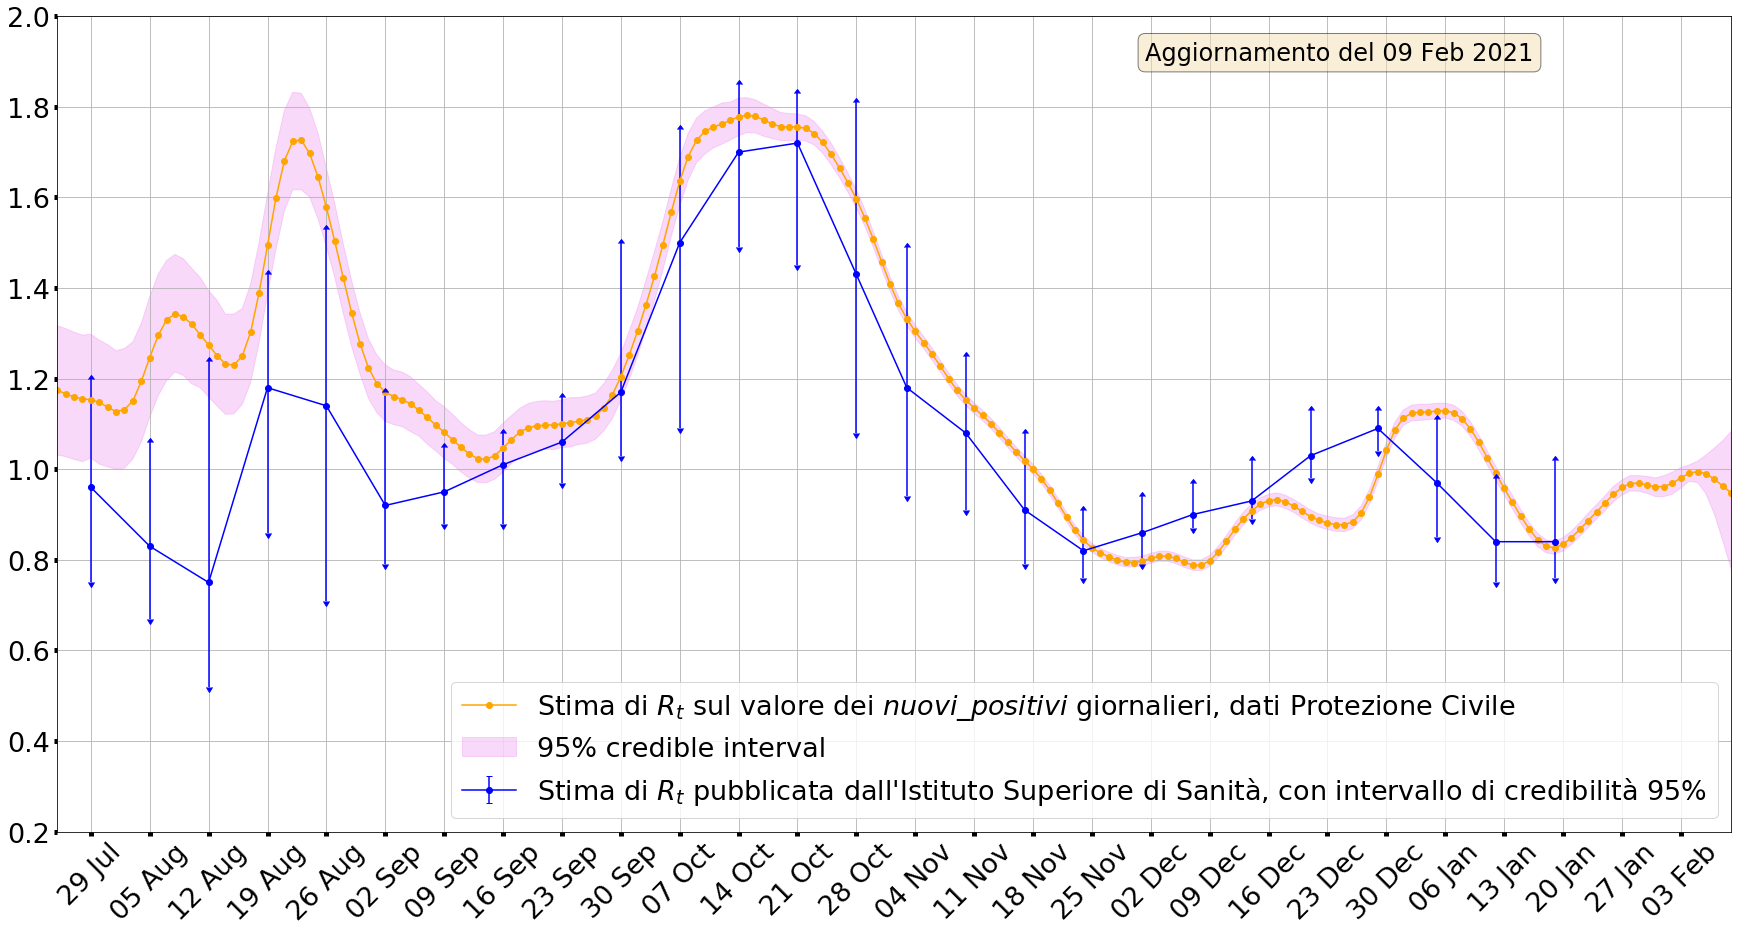

In [89]:
plot_MCMC_sampling(
    italy_raw_data, 
    'nuovi_positivi_smoothed', 
    ISS_Rt_clean,
    xlim=(datetime(2020,7,25),italy_raw_data.data.dt.normalize().max()), 
    std=False, 
    average=False, 
    ylim=(0.2,2),
    path=SAVE_IMAGE_PATH,
    dpi=150
)

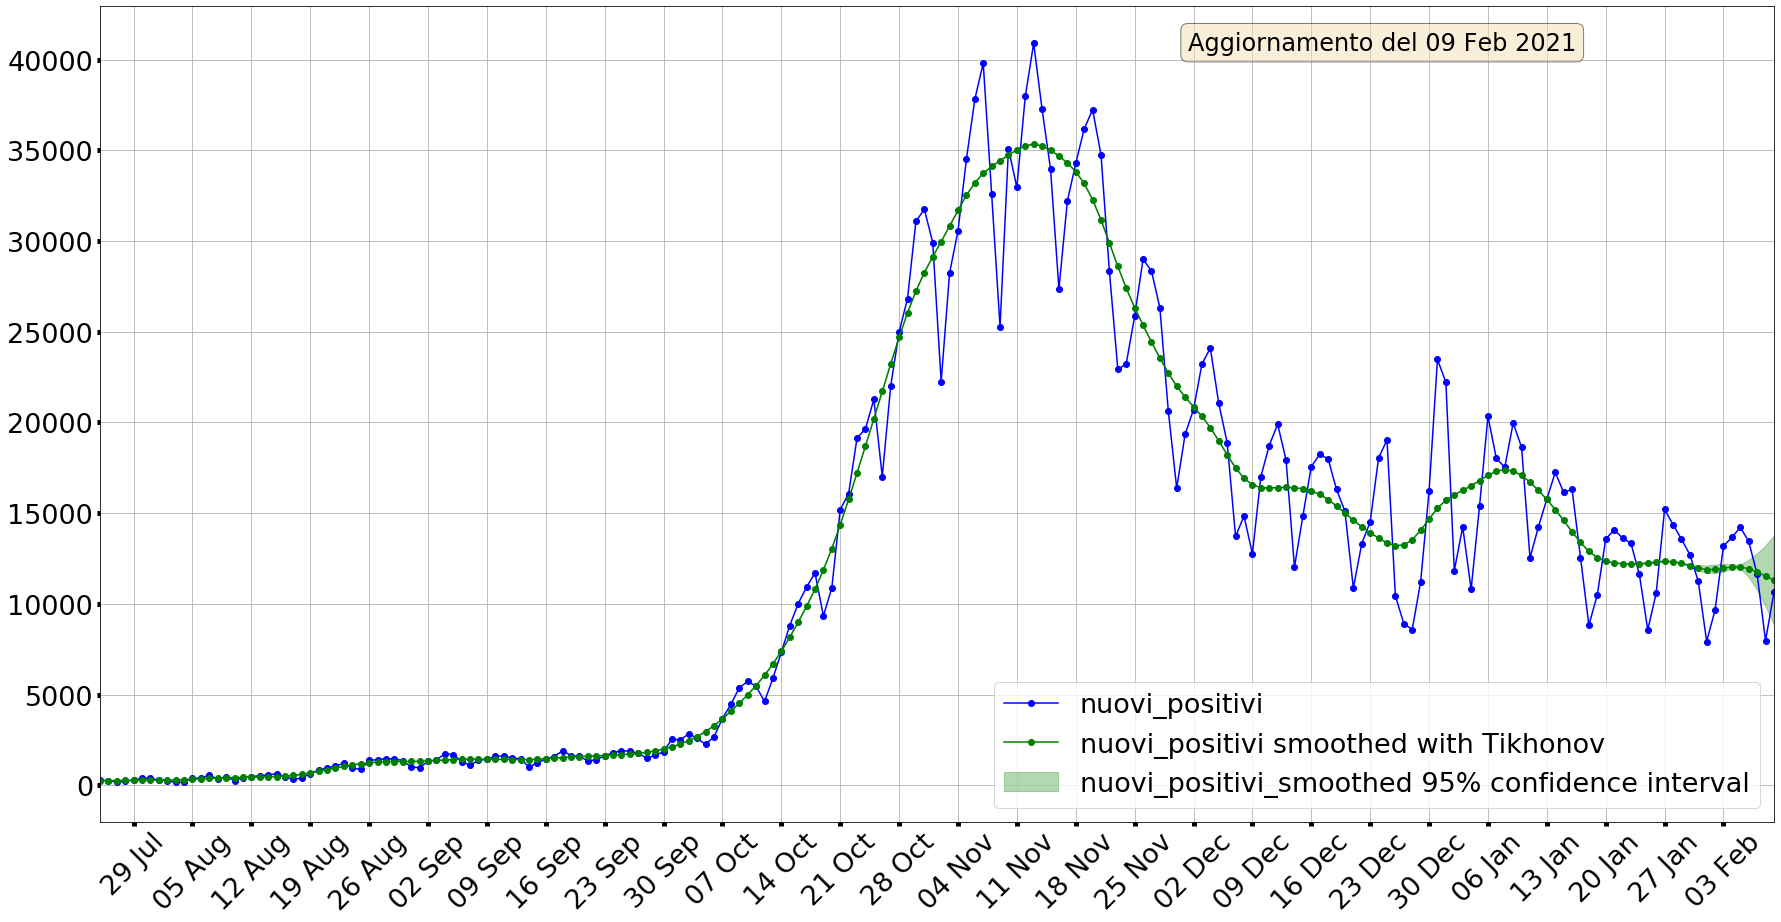

In [91]:
plot_differences_with_uncertainty(
    italy_raw_data, 'nuovi_positivi_smoothed_uncertainty', 
    smoothed_default=None,
    xlim=(datetime(2020,7,25),italy_raw_data.data.dt.normalize().max()),
    path=os.path.join(BASE_IMAGES_PATH,'20210210_nuovi_positivi.{}'), dpi=300
)